# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

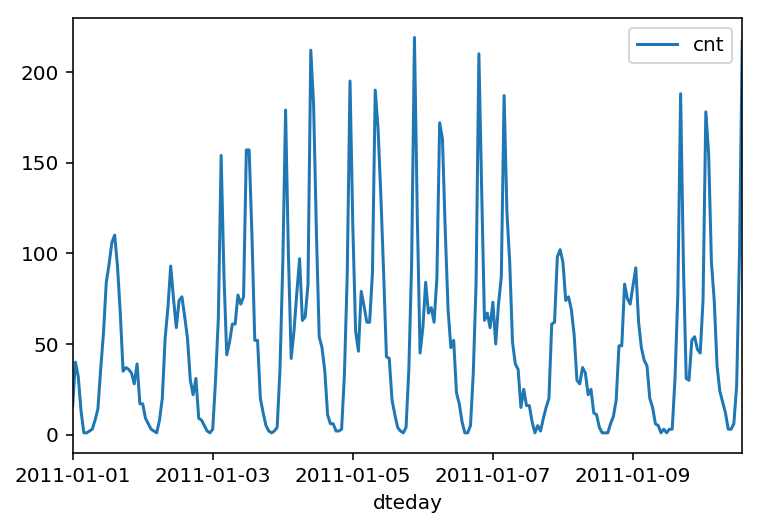

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [9]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        self.activation_function = lambda x : 1/(1+np.exp(-x))  # Replace 0 with your sigmoid calculation.
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        #def sigmoid(x):
        #    return 0  # Replace 0 with your sigmoid calculation here
        #self.activation_function = sigmoid
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        print('n_records is: ' + str(n_records))
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output) # signals into final output layer
            final_outputs = final_inputs # signals from final output layer
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # TODO: Output error - Replace this value with your calculations.
            error = y - final_outputs # Output layer error is the difference between desired target and actual output.
            
            output_error_term = error * 1
            
            # TODO: Calculate the hidden layer's contribution to the error
            hidden_error = np.dot(self.weights_hidden_to_output, output_error_term)
            
            # TODO: Backpropagated error terms - Replace these values with your calculations.
#             output_error_term = error * 1
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)

            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term.T * X[:, None]
            # Weight step (hidden to output)
            delta_weights_h_o += output_error_term * hidden_outputs[:, None]

        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records # update input-to-hidden weights with gradient descent step
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
#         for X in zip(features):
            
        # TODO: Hidden layer - replace these values with the appropriate calculations.
#         hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # signals into hidden 
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output)  # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs

In [10]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [11]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....

n_records is: 1



----------------------------------------------------------------------
Ran 5 tests in 0.023s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, if you use too many iterations, then the model with not generalize well to other data, this is called overfitting. You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. As you start overfitting, you'll see the training loss continue to decrease while the validation loss starts to increase.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. Normally a good choice to start at is 0.1; however, if you effectively divide the learning rate by n_records, try starting out with a learning rate of 1. In either case, if the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [12]:
import sys

### Set the hyperparameters here ###
iterations = 20000
learning_rate = 0.2
hidden_nodes = 30
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}

for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

n_records is: 128
Progress: 0.0% ... Training loss: 1.044 ... Validation loss: 1.491n_records is: 128
Progress: 0.0% ... Training loss: 1.080 ... Validation loss: 1.298n_records is: 128
Progress: 0.0% ... Training loss: 0.993 ... Validation loss: 1.364n_records is: 128
Progress: 0.0% ... Training loss: 0.985 ... Validation loss: 1.411n_records is: 128
Progress: 0.0% ... Training loss: 1.027 ... Validation loss: 1.566n_records is: 128
Progress: 0.0% ... Training loss: 0.962 ... Validation loss: 1.352n_records is: 128
Progress: 0.0% ... Training loss: 1.015 ... Validation loss: 1.575n_records is: 128
Progress: 0.0% ... Training loss: 1.050 ... Validation loss: 1.258n_records is: 128
Progress: 0.0% ... Training loss: 0.948 ... Validation loss: 1.445n_records is: 128
Progress: 0.0% ... Training loss: 0.987 ... Validation loss: 1.248n_records is: 128
Progress: 0.1% ... Training loss: 0.972 ... Validation loss: 1.561n_records is: 128
Progress: 0.1% ... Training loss: 0.942 ... Validation los

Progress: 1.0% ... Training loss: 0.506 ... Validation loss: 0.839n_records is: 128
Progress: 1.0% ... Training loss: 0.506 ... Validation loss: 0.845n_records is: 128
Progress: 1.0% ... Training loss: 0.517 ... Validation loss: 0.797n_records is: 128
Progress: 1.0% ... Training loss: 0.509 ... Validation loss: 0.797n_records is: 128
Progress: 1.0% ... Training loss: 0.503 ... Validation loss: 0.798n_records is: 128
Progress: 1.0% ... Training loss: 0.507 ... Validation loss: 0.790n_records is: 128
Progress: 1.0% ... Training loss: 0.533 ... Validation loss: 0.909n_records is: 128
Progress: 1.0% ... Training loss: 0.541 ... Validation loss: 0.785n_records is: 128
Progress: 1.0% ... Training loss: 0.533 ... Validation loss: 0.911n_records is: 128
Progress: 1.0% ... Training loss: 0.494 ... Validation loss: 0.803n_records is: 128
Progress: 1.0% ... Training loss: 0.501 ... Validation loss: 0.784n_records is: 128
Progress: 1.0% ... Training loss: 0.493 ... Validation loss: 0.816n_records 

Progress: 1.9% ... Training loss: 0.390 ... Validation loss: 0.605n_records is: 128
Progress: 1.9% ... Training loss: 0.364 ... Validation loss: 0.559n_records is: 128
Progress: 1.9% ... Training loss: 0.365 ... Validation loss: 0.575n_records is: 128
Progress: 2.0% ... Training loss: 0.342 ... Validation loss: 0.546n_records is: 128
Progress: 2.0% ... Training loss: 0.343 ... Validation loss: 0.548n_records is: 128
Progress: 2.0% ... Training loss: 0.361 ... Validation loss: 0.569n_records is: 128
Progress: 2.0% ... Training loss: 0.349 ... Validation loss: 0.557n_records is: 128
Progress: 2.0% ... Training loss: 0.355 ... Validation loss: 0.564n_records is: 128
Progress: 2.0% ... Training loss: 0.341 ... Validation loss: 0.550n_records is: 128
Progress: 2.0% ... Training loss: 0.339 ... Validation loss: 0.546n_records is: 128
Progress: 2.0% ... Training loss: 0.341 ... Validation loss: 0.548n_records is: 128
Progress: 2.0% ... Training loss: 0.348 ... Validation loss: 0.553n_records 

Progress: 2.9% ... Training loss: 0.308 ... Validation loss: 0.476n_records is: 128
Progress: 2.9% ... Training loss: 0.304 ... Validation loss: 0.472n_records is: 128
Progress: 2.9% ... Training loss: 0.307 ... Validation loss: 0.473n_records is: 128
Progress: 2.9% ... Training loss: 0.306 ... Validation loss: 0.473n_records is: 128
Progress: 2.9% ... Training loss: 0.304 ... Validation loss: 0.472n_records is: 128
Progress: 2.9% ... Training loss: 0.322 ... Validation loss: 0.488n_records is: 128
Progress: 2.9% ... Training loss: 0.310 ... Validation loss: 0.476n_records is: 128
Progress: 2.9% ... Training loss: 0.310 ... Validation loss: 0.480n_records is: 128
Progress: 3.0% ... Training loss: 0.306 ... Validation loss: 0.477n_records is: 128
Progress: 3.0% ... Training loss: 0.315 ... Validation loss: 0.485n_records is: 128
Progress: 3.0% ... Training loss: 0.309 ... Validation loss: 0.479n_records is: 128
Progress: 3.0% ... Training loss: 0.316 ... Validation loss: 0.486n_records 

Progress: 3.9% ... Training loss: 0.328 ... Validation loss: 0.489n_records is: 128
Progress: 3.9% ... Training loss: 0.306 ... Validation loss: 0.477n_records is: 128
Progress: 3.9% ... Training loss: 0.319 ... Validation loss: 0.483n_records is: 128
Progress: 3.9% ... Training loss: 0.306 ... Validation loss: 0.476n_records is: 128
Progress: 3.9% ... Training loss: 0.297 ... Validation loss: 0.459n_records is: 128
Progress: 3.9% ... Training loss: 0.297 ... Validation loss: 0.459n_records is: 128
Progress: 3.9% ... Training loss: 0.296 ... Validation loss: 0.463n_records is: 128
Progress: 3.9% ... Training loss: 0.296 ... Validation loss: 0.460n_records is: 128
Progress: 3.9% ... Training loss: 0.297 ... Validation loss: 0.460n_records is: 128
Progress: 3.9% ... Training loss: 0.298 ... Validation loss: 0.460n_records is: 128
Progress: 3.9% ... Training loss: 0.298 ... Validation loss: 0.466n_records is: 128
Progress: 3.9% ... Training loss: 0.297 ... Validation loss: 0.462n_records 

Progress: 4.8% ... Training loss: 0.316 ... Validation loss: 0.492n_records is: 128
Progress: 4.9% ... Training loss: 0.297 ... Validation loss: 0.462n_records is: 128
Progress: 4.9% ... Training loss: 0.311 ... Validation loss: 0.476n_records is: 128
Progress: 4.9% ... Training loss: 0.304 ... Validation loss: 0.477n_records is: 128
Progress: 4.9% ... Training loss: 0.339 ... Validation loss: 0.510n_records is: 128
Progress: 4.9% ... Training loss: 0.293 ... Validation loss: 0.461n_records is: 128
Progress: 4.9% ... Training loss: 0.296 ... Validation loss: 0.465n_records is: 128
Progress: 4.9% ... Training loss: 0.293 ... Validation loss: 0.462n_records is: 128
Progress: 4.9% ... Training loss: 0.290 ... Validation loss: 0.459n_records is: 128
Progress: 4.9% ... Training loss: 0.290 ... Validation loss: 0.458n_records is: 128
Progress: 4.9% ... Training loss: 0.289 ... Validation loss: 0.460n_records is: 128
Progress: 4.9% ... Training loss: 0.291 ... Validation loss: 0.463n_records 

Progress: 5.8% ... Training loss: 0.283 ... Validation loss: 0.453n_records is: 128
Progress: 5.8% ... Training loss: 0.319 ... Validation loss: 0.500n_records is: 128
Progress: 5.8% ... Training loss: 0.323 ... Validation loss: 0.486n_records is: 128
Progress: 5.8% ... Training loss: 0.333 ... Validation loss: 0.523n_records is: 128
Progress: 5.8% ... Training loss: 0.300 ... Validation loss: 0.463n_records is: 128
Progress: 5.8% ... Training loss: 0.284 ... Validation loss: 0.452n_records is: 128
Progress: 5.8% ... Training loss: 0.285 ... Validation loss: 0.449n_records is: 128
Progress: 5.9% ... Training loss: 0.282 ... Validation loss: 0.447n_records is: 128
Progress: 5.9% ... Training loss: 0.282 ... Validation loss: 0.448n_records is: 128
Progress: 5.9% ... Training loss: 0.282 ... Validation loss: 0.448n_records is: 128
Progress: 5.9% ... Training loss: 0.285 ... Validation loss: 0.449n_records is: 128
Progress: 5.9% ... Training loss: 0.299 ... Validation loss: 0.465n_records 

Progress: 6.8% ... Training loss: 0.291 ... Validation loss: 0.470n_records is: 128
Progress: 6.8% ... Training loss: 0.291 ... Validation loss: 0.463n_records is: 128
Progress: 6.8% ... Training loss: 0.278 ... Validation loss: 0.453n_records is: 128
Progress: 6.8% ... Training loss: 0.277 ... Validation loss: 0.449n_records is: 128
Progress: 6.8% ... Training loss: 0.296 ... Validation loss: 0.466n_records is: 128
Progress: 6.8% ... Training loss: 0.278 ... Validation loss: 0.453n_records is: 128
Progress: 6.8% ... Training loss: 0.298 ... Validation loss: 0.473n_records is: 128
Progress: 6.8% ... Training loss: 0.280 ... Validation loss: 0.455n_records is: 128
Progress: 6.8% ... Training loss: 0.279 ... Validation loss: 0.455n_records is: 128
Progress: 6.8% ... Training loss: 0.305 ... Validation loss: 0.483n_records is: 128
Progress: 6.8% ... Training loss: 0.287 ... Validation loss: 0.462n_records is: 128
Progress: 6.8% ... Training loss: 0.277 ... Validation loss: 0.454n_records 

Progress: 7.8% ... Training loss: 0.274 ... Validation loss: 0.451n_records is: 128
Progress: 7.8% ... Training loss: 0.284 ... Validation loss: 0.464n_records is: 128
Progress: 7.8% ... Training loss: 0.275 ... Validation loss: 0.453n_records is: 128
Progress: 7.8% ... Training loss: 0.280 ... Validation loss: 0.461n_records is: 128
Progress: 7.8% ... Training loss: 0.274 ... Validation loss: 0.454n_records is: 128
Progress: 7.8% ... Training loss: 0.284 ... Validation loss: 0.464n_records is: 128
Progress: 7.8% ... Training loss: 0.274 ... Validation loss: 0.452n_records is: 128
Progress: 7.8% ... Training loss: 0.274 ... Validation loss: 0.448n_records is: 128
Progress: 7.8% ... Training loss: 0.278 ... Validation loss: 0.448n_records is: 128
Progress: 7.8% ... Training loss: 0.278 ... Validation loss: 0.452n_records is: 128
Progress: 7.8% ... Training loss: 0.273 ... Validation loss: 0.446n_records is: 128
Progress: 7.8% ... Training loss: 0.290 ... Validation loss: 0.458n_records 

Progress: 8.7% ... Training loss: 0.273 ... Validation loss: 0.457n_records is: 128
Progress: 8.7% ... Training loss: 0.272 ... Validation loss: 0.452n_records is: 128
Progress: 8.7% ... Training loss: 0.282 ... Validation loss: 0.469n_records is: 128
Progress: 8.7% ... Training loss: 0.278 ... Validation loss: 0.458n_records is: 128
Progress: 8.8% ... Training loss: 0.274 ... Validation loss: 0.462n_records is: 128
Progress: 8.8% ... Training loss: 0.271 ... Validation loss: 0.453n_records is: 128
Progress: 8.8% ... Training loss: 0.271 ... Validation loss: 0.453n_records is: 128
Progress: 8.8% ... Training loss: 0.276 ... Validation loss: 0.455n_records is: 128
Progress: 8.8% ... Training loss: 0.284 ... Validation loss: 0.465n_records is: 128
Progress: 8.8% ... Training loss: 0.280 ... Validation loss: 0.457n_records is: 128
Progress: 8.8% ... Training loss: 0.274 ... Validation loss: 0.453n_records is: 128
Progress: 8.8% ... Training loss: 0.270 ... Validation loss: 0.449n_records 

Progress: 9.7% ... Training loss: 0.272 ... Validation loss: 0.459n_records is: 128
Progress: 9.7% ... Training loss: 0.270 ... Validation loss: 0.452n_records is: 128
Progress: 9.7% ... Training loss: 0.270 ... Validation loss: 0.452n_records is: 128
Progress: 9.7% ... Training loss: 0.268 ... Validation loss: 0.452n_records is: 128
Progress: 9.7% ... Training loss: 0.267 ... Validation loss: 0.451n_records is: 128
Progress: 9.7% ... Training loss: 0.267 ... Validation loss: 0.452n_records is: 128
Progress: 9.7% ... Training loss: 0.270 ... Validation loss: 0.452n_records is: 128
Progress: 9.7% ... Training loss: 0.268 ... Validation loss: 0.446n_records is: 128
Progress: 9.7% ... Training loss: 0.272 ... Validation loss: 0.455n_records is: 128
Progress: 9.7% ... Training loss: 0.268 ... Validation loss: 0.450n_records is: 128
Progress: 9.8% ... Training loss: 0.267 ... Validation loss: 0.448n_records is: 128
Progress: 9.8% ... Training loss: 0.317 ... Validation loss: 0.498n_records 

Progress: 10.2% ... Training loss: 0.267 ... Validation loss: 0.449n_records is: 128
Progress: 10.2% ... Training loss: 0.268 ... Validation loss: 0.449n_records is: 128
Progress: 10.2% ... Training loss: 0.272 ... Validation loss: 0.458n_records is: 128
Progress: 10.2% ... Training loss: 0.276 ... Validation loss: 0.453n_records is: 128
Progress: 10.2% ... Training loss: 0.268 ... Validation loss: 0.451n_records is: 128
Progress: 10.2% ... Training loss: 0.266 ... Validation loss: 0.448n_records is: 128
Progress: 10.2% ... Training loss: 0.298 ... Validation loss: 0.470n_records is: 128
Progress: 10.2% ... Training loss: 0.321 ... Validation loss: 0.521n_records is: 128
Progress: 10.2% ... Training loss: 0.285 ... Validation loss: 0.460n_records is: 128
Progress: 10.2% ... Training loss: 0.270 ... Validation loss: 0.458n_records is: 128
Progress: 10.2% ... Training loss: 0.268 ... Validation loss: 0.450n_records is: 128
Progress: 10.2% ... Training loss: 0.274 ... Validation loss: 0.4

Progress: 11.1% ... Training loss: 0.266 ... Validation loss: 0.450n_records is: 128
Progress: 11.2% ... Training loss: 0.264 ... Validation loss: 0.448n_records is: 128
Progress: 11.2% ... Training loss: 0.272 ... Validation loss: 0.456n_records is: 128
Progress: 11.2% ... Training loss: 0.271 ... Validation loss: 0.454n_records is: 128
Progress: 11.2% ... Training loss: 0.276 ... Validation loss: 0.464n_records is: 128
Progress: 11.2% ... Training loss: 0.273 ... Validation loss: 0.456n_records is: 128
Progress: 11.2% ... Training loss: 0.267 ... Validation loss: 0.446n_records is: 128
Progress: 11.2% ... Training loss: 0.278 ... Validation loss: 0.458n_records is: 128
Progress: 11.2% ... Training loss: 0.265 ... Validation loss: 0.446n_records is: 128
Progress: 11.2% ... Training loss: 0.264 ... Validation loss: 0.446n_records is: 128
Progress: 11.2% ... Training loss: 0.268 ... Validation loss: 0.454n_records is: 128
Progress: 11.2% ... Training loss: 0.267 ... Validation loss: 0.4

Progress: 12.1% ... Training loss: 0.264 ... Validation loss: 0.448n_records is: 128
Progress: 12.1% ... Training loss: 0.266 ... Validation loss: 0.450n_records is: 128
Progress: 12.1% ... Training loss: 0.262 ... Validation loss: 0.444n_records is: 128
Progress: 12.1% ... Training loss: 0.274 ... Validation loss: 0.450n_records is: 128
Progress: 12.1% ... Training loss: 0.264 ... Validation loss: 0.443n_records is: 128
Progress: 12.1% ... Training loss: 0.267 ... Validation loss: 0.448n_records is: 128
Progress: 12.1% ... Training loss: 0.295 ... Validation loss: 0.480n_records is: 128
Progress: 12.1% ... Training loss: 0.273 ... Validation loss: 0.459n_records is: 128
Progress: 12.1% ... Training loss: 0.268 ... Validation loss: 0.451n_records is: 128
Progress: 12.2% ... Training loss: 0.280 ... Validation loss: 0.469n_records is: 128
Progress: 12.2% ... Training loss: 0.265 ... Validation loss: 0.447n_records is: 128
Progress: 12.2% ... Training loss: 0.262 ... Validation loss: 0.4

Progress: 13.1% ... Training loss: 0.272 ... Validation loss: 0.447n_records is: 128
Progress: 13.1% ... Training loss: 0.285 ... Validation loss: 0.462n_records is: 128
Progress: 13.1% ... Training loss: 0.277 ... Validation loss: 0.469n_records is: 128
Progress: 13.1% ... Training loss: 0.263 ... Validation loss: 0.445n_records is: 128
Progress: 13.1% ... Training loss: 0.265 ... Validation loss: 0.444n_records is: 128
Progress: 13.1% ... Training loss: 0.294 ... Validation loss: 0.481n_records is: 128
Progress: 13.1% ... Training loss: 0.279 ... Validation loss: 0.462n_records is: 128
Progress: 13.1% ... Training loss: 0.276 ... Validation loss: 0.463n_records is: 128
Progress: 13.1% ... Training loss: 0.260 ... Validation loss: 0.443n_records is: 128
Progress: 13.1% ... Training loss: 0.262 ... Validation loss: 0.448n_records is: 128
Progress: 13.1% ... Training loss: 0.306 ... Validation loss: 0.489n_records is: 128
Progress: 13.1% ... Training loss: 0.287 ... Validation loss: 0.4

Progress: 14.0% ... Training loss: 0.257 ... Validation loss: 0.441n_records is: 128
Progress: 14.0% ... Training loss: 0.257 ... Validation loss: 0.445n_records is: 128
Progress: 14.0% ... Training loss: 0.257 ... Validation loss: 0.442n_records is: 128
Progress: 14.0% ... Training loss: 0.257 ... Validation loss: 0.443n_records is: 128
Progress: 14.0% ... Training loss: 0.258 ... Validation loss: 0.443n_records is: 128
Progress: 14.1% ... Training loss: 0.257 ... Validation loss: 0.442n_records is: 128
Progress: 14.1% ... Training loss: 0.259 ... Validation loss: 0.440n_records is: 128
Progress: 14.1% ... Training loss: 0.260 ... Validation loss: 0.443n_records is: 128
Progress: 14.1% ... Training loss: 0.278 ... Validation loss: 0.469n_records is: 128
Progress: 14.1% ... Training loss: 0.258 ... Validation loss: 0.440n_records is: 128
Progress: 14.1% ... Training loss: 0.258 ... Validation loss: 0.445n_records is: 128
Progress: 14.1% ... Training loss: 0.261 ... Validation loss: 0.4

Progress: 15.0% ... Training loss: 0.258 ... Validation loss: 0.440n_records is: 128
Progress: 15.0% ... Training loss: 0.261 ... Validation loss: 0.448n_records is: 128
Progress: 15.0% ... Training loss: 0.260 ... Validation loss: 0.446n_records is: 128
Progress: 15.0% ... Training loss: 0.263 ... Validation loss: 0.445n_records is: 128
Progress: 15.0% ... Training loss: 0.257 ... Validation loss: 0.440n_records is: 128
Progress: 15.0% ... Training loss: 0.257 ... Validation loss: 0.439n_records is: 128
Progress: 15.0% ... Training loss: 0.254 ... Validation loss: 0.438n_records is: 128
Progress: 15.0% ... Training loss: 0.270 ... Validation loss: 0.452n_records is: 128
Progress: 15.0% ... Training loss: 0.254 ... Validation loss: 0.437n_records is: 128
Progress: 15.0% ... Training loss: 0.267 ... Validation loss: 0.450n_records is: 128
Progress: 15.0% ... Training loss: 0.288 ... Validation loss: 0.478n_records is: 128
Progress: 15.0% ... Training loss: 0.278 ... Validation loss: 0.4

Progress: 15.9% ... Training loss: 0.252 ... Validation loss: 0.434n_records is: 128
Progress: 15.9% ... Training loss: 0.251 ... Validation loss: 0.435n_records is: 128
Progress: 16.0% ... Training loss: 0.268 ... Validation loss: 0.457n_records is: 128
Progress: 16.0% ... Training loss: 0.252 ... Validation loss: 0.441n_records is: 128
Progress: 16.0% ... Training loss: 0.253 ... Validation loss: 0.440n_records is: 128
Progress: 16.0% ... Training loss: 0.259 ... Validation loss: 0.441n_records is: 128
Progress: 16.0% ... Training loss: 0.265 ... Validation loss: 0.454n_records is: 128
Progress: 16.0% ... Training loss: 0.272 ... Validation loss: 0.452n_records is: 128
Progress: 16.0% ... Training loss: 0.253 ... Validation loss: 0.431n_records is: 128
Progress: 16.0% ... Training loss: 0.253 ... Validation loss: 0.433n_records is: 128
Progress: 16.0% ... Training loss: 0.274 ... Validation loss: 0.456n_records is: 128
Progress: 16.0% ... Training loss: 0.282 ... Validation loss: 0.4

Progress: 16.9% ... Training loss: 0.251 ... Validation loss: 0.446n_records is: 128
Progress: 16.9% ... Training loss: 0.263 ... Validation loss: 0.454n_records is: 128
Progress: 16.9% ... Training loss: 0.258 ... Validation loss: 0.455n_records is: 128
Progress: 16.9% ... Training loss: 0.254 ... Validation loss: 0.442n_records is: 128
Progress: 16.9% ... Training loss: 0.250 ... Validation loss: 0.439n_records is: 128
Progress: 16.9% ... Training loss: 0.271 ... Validation loss: 0.457n_records is: 128
Progress: 16.9% ... Training loss: 0.277 ... Validation loss: 0.462n_records is: 128
Progress: 16.9% ... Training loss: 0.272 ... Validation loss: 0.462n_records is: 128
Progress: 16.9% ... Training loss: 0.254 ... Validation loss: 0.438n_records is: 128
Progress: 16.9% ... Training loss: 0.250 ... Validation loss: 0.435n_records is: 128
Progress: 17.0% ... Training loss: 0.249 ... Validation loss: 0.434n_records is: 128
Progress: 17.0% ... Training loss: 0.251 ... Validation loss: 0.4

Progress: 17.9% ... Training loss: 0.295 ... Validation loss: 0.494n_records is: 128
Progress: 17.9% ... Training loss: 0.247 ... Validation loss: 0.425n_records is: 128
Progress: 17.9% ... Training loss: 0.262 ... Validation loss: 0.449n_records is: 128
Progress: 17.9% ... Training loss: 0.282 ... Validation loss: 0.450n_records is: 128
Progress: 17.9% ... Training loss: 0.254 ... Validation loss: 0.437n_records is: 128
Progress: 17.9% ... Training loss: 0.253 ... Validation loss: 0.426n_records is: 128
Progress: 17.9% ... Training loss: 0.246 ... Validation loss: 0.429n_records is: 128
Progress: 17.9% ... Training loss: 0.247 ... Validation loss: 0.427n_records is: 128
Progress: 17.9% ... Training loss: 0.254 ... Validation loss: 0.443n_records is: 128
Progress: 17.9% ... Training loss: 0.291 ... Validation loss: 0.451n_records is: 128
Progress: 17.9% ... Training loss: 0.307 ... Validation loss: 0.520n_records is: 128
Progress: 17.9% ... Training loss: 0.261 ... Validation loss: 0.4

Progress: 18.8% ... Training loss: 0.243 ... Validation loss: 0.419n_records is: 128
Progress: 18.8% ... Training loss: 0.245 ... Validation loss: 0.420n_records is: 128
Progress: 18.8% ... Training loss: 0.243 ... Validation loss: 0.420n_records is: 128
Progress: 18.8% ... Training loss: 0.242 ... Validation loss: 0.420n_records is: 128
Progress: 18.8% ... Training loss: 0.247 ... Validation loss: 0.423n_records is: 128
Progress: 18.9% ... Training loss: 0.249 ... Validation loss: 0.428n_records is: 128
Progress: 18.9% ... Training loss: 0.260 ... Validation loss: 0.444n_records is: 128
Progress: 18.9% ... Training loss: 0.242 ... Validation loss: 0.420n_records is: 128
Progress: 18.9% ... Training loss: 0.243 ... Validation loss: 0.422n_records is: 128
Progress: 18.9% ... Training loss: 0.242 ... Validation loss: 0.420n_records is: 128
Progress: 18.9% ... Training loss: 0.243 ... Validation loss: 0.422n_records is: 128
Progress: 18.9% ... Training loss: 0.243 ... Validation loss: 0.4

Progress: 19.8% ... Training loss: 0.244 ... Validation loss: 0.427n_records is: 128
Progress: 19.8% ... Training loss: 0.249 ... Validation loss: 0.437n_records is: 128
Progress: 19.8% ... Training loss: 0.240 ... Validation loss: 0.425n_records is: 128
Progress: 19.8% ... Training loss: 0.239 ... Validation loss: 0.426n_records is: 128
Progress: 19.8% ... Training loss: 0.239 ... Validation loss: 0.426n_records is: 128
Progress: 19.8% ... Training loss: 0.240 ... Validation loss: 0.426n_records is: 128
Progress: 19.8% ... Training loss: 0.241 ... Validation loss: 0.427n_records is: 128
Progress: 19.8% ... Training loss: 0.240 ... Validation loss: 0.423n_records is: 128
Progress: 19.8% ... Training loss: 0.238 ... Validation loss: 0.422n_records is: 128
Progress: 19.8% ... Training loss: 0.239 ... Validation loss: 0.422n_records is: 128
Progress: 19.8% ... Training loss: 0.241 ... Validation loss: 0.424n_records is: 128
Progress: 19.8% ... Training loss: 0.240 ... Validation loss: 0.4

Progress: 20.7% ... Training loss: 0.240 ... Validation loss: 0.417n_records is: 128
Progress: 20.8% ... Training loss: 0.251 ... Validation loss: 0.422n_records is: 128
Progress: 20.8% ... Training loss: 0.237 ... Validation loss: 0.414n_records is: 128
Progress: 20.8% ... Training loss: 0.255 ... Validation loss: 0.433n_records is: 128
Progress: 20.8% ... Training loss: 0.235 ... Validation loss: 0.412n_records is: 128
Progress: 20.8% ... Training loss: 0.234 ... Validation loss: 0.410n_records is: 128
Progress: 20.8% ... Training loss: 0.234 ... Validation loss: 0.412n_records is: 128
Progress: 20.8% ... Training loss: 0.246 ... Validation loss: 0.421n_records is: 128
Progress: 20.8% ... Training loss: 0.265 ... Validation loss: 0.447n_records is: 128
Progress: 20.8% ... Training loss: 0.234 ... Validation loss: 0.410n_records is: 128
Progress: 20.8% ... Training loss: 0.236 ... Validation loss: 0.410n_records is: 128
Progress: 20.8% ... Training loss: 0.235 ... Validation loss: 0.4

Progress: 21.7% ... Training loss: 0.229 ... Validation loss: 0.412n_records is: 128
Progress: 21.7% ... Training loss: 0.239 ... Validation loss: 0.418n_records is: 128
Progress: 21.7% ... Training loss: 0.232 ... Validation loss: 0.410n_records is: 128
Progress: 21.7% ... Training loss: 0.231 ... Validation loss: 0.409n_records is: 128
Progress: 21.7% ... Training loss: 0.237 ... Validation loss: 0.418n_records is: 128
Progress: 21.7% ... Training loss: 0.237 ... Validation loss: 0.415n_records is: 128
Progress: 21.7% ... Training loss: 0.229 ... Validation loss: 0.410n_records is: 128
Progress: 21.7% ... Training loss: 0.232 ... Validation loss: 0.414n_records is: 128
Progress: 21.7% ... Training loss: 0.238 ... Validation loss: 0.422n_records is: 128
Progress: 21.8% ... Training loss: 0.231 ... Validation loss: 0.414n_records is: 128
Progress: 21.8% ... Training loss: 0.231 ... Validation loss: 0.414n_records is: 128
Progress: 21.8% ... Training loss: 0.233 ... Validation loss: 0.4

Progress: 22.7% ... Training loss: 0.227 ... Validation loss: 0.395n_records is: 128
Progress: 22.7% ... Training loss: 0.228 ... Validation loss: 0.396n_records is: 128
Progress: 22.7% ... Training loss: 0.225 ... Validation loss: 0.390n_records is: 128
Progress: 22.7% ... Training loss: 0.227 ... Validation loss: 0.392n_records is: 128
Progress: 22.7% ... Training loss: 0.225 ... Validation loss: 0.391n_records is: 128
Progress: 22.7% ... Training loss: 0.223 ... Validation loss: 0.389n_records is: 128
Progress: 22.7% ... Training loss: 0.239 ... Validation loss: 0.406n_records is: 128
Progress: 22.7% ... Training loss: 0.238 ... Validation loss: 0.405n_records is: 128
Progress: 22.7% ... Training loss: 0.228 ... Validation loss: 0.406n_records is: 128
Progress: 22.7% ... Training loss: 0.235 ... Validation loss: 0.403n_records is: 128
Progress: 22.7% ... Training loss: 0.223 ... Validation loss: 0.394n_records is: 128
Progress: 22.7% ... Training loss: 0.223 ... Validation loss: 0.3

Progress: 23.6% ... Training loss: 0.226 ... Validation loss: 0.394n_records is: 128
Progress: 23.6% ... Training loss: 0.219 ... Validation loss: 0.391n_records is: 128
Progress: 23.6% ... Training loss: 0.217 ... Validation loss: 0.388n_records is: 128
Progress: 23.6% ... Training loss: 0.223 ... Validation loss: 0.394n_records is: 128
Progress: 23.6% ... Training loss: 0.223 ... Validation loss: 0.398n_records is: 128
Progress: 23.6% ... Training loss: 0.226 ... Validation loss: 0.395n_records is: 128
Progress: 23.7% ... Training loss: 0.219 ... Validation loss: 0.390n_records is: 128
Progress: 23.7% ... Training loss: 0.216 ... Validation loss: 0.388n_records is: 128
Progress: 23.7% ... Training loss: 0.216 ... Validation loss: 0.387n_records is: 128
Progress: 23.7% ... Training loss: 0.220 ... Validation loss: 0.389n_records is: 128
Progress: 23.7% ... Training loss: 0.243 ... Validation loss: 0.414n_records is: 128
Progress: 23.7% ... Training loss: 0.245 ... Validation loss: 0.4

Progress: 24.6% ... Training loss: 0.212 ... Validation loss: 0.380n_records is: 128
Progress: 24.6% ... Training loss: 0.213 ... Validation loss: 0.376n_records is: 128
Progress: 24.6% ... Training loss: 0.211 ... Validation loss: 0.375n_records is: 128
Progress: 24.6% ... Training loss: 0.222 ... Validation loss: 0.392n_records is: 128
Progress: 24.6% ... Training loss: 0.218 ... Validation loss: 0.380n_records is: 128
Progress: 24.6% ... Training loss: 0.209 ... Validation loss: 0.376n_records is: 128
Progress: 24.6% ... Training loss: 0.225 ... Validation loss: 0.392n_records is: 128
Progress: 24.6% ... Training loss: 0.222 ... Validation loss: 0.383n_records is: 128
Progress: 24.6% ... Training loss: 0.211 ... Validation loss: 0.379n_records is: 128
Progress: 24.6% ... Training loss: 0.227 ... Validation loss: 0.387n_records is: 128
Progress: 24.6% ... Training loss: 0.225 ... Validation loss: 0.400n_records is: 128
Progress: 24.6% ... Training loss: 0.222 ... Validation loss: 0.3

Progress: 25.5% ... Training loss: 0.205 ... Validation loss: 0.375n_records is: 128
Progress: 25.6% ... Training loss: 0.202 ... Validation loss: 0.368n_records is: 128
Progress: 25.6% ... Training loss: 0.208 ... Validation loss: 0.378n_records is: 128
Progress: 25.6% ... Training loss: 0.204 ... Validation loss: 0.367n_records is: 128
Progress: 25.6% ... Training loss: 0.205 ... Validation loss: 0.369n_records is: 128
Progress: 25.6% ... Training loss: 0.203 ... Validation loss: 0.373n_records is: 128
Progress: 25.6% ... Training loss: 0.203 ... Validation loss: 0.367n_records is: 128
Progress: 25.6% ... Training loss: 0.206 ... Validation loss: 0.368n_records is: 128
Progress: 25.6% ... Training loss: 0.203 ... Validation loss: 0.370n_records is: 128
Progress: 25.6% ... Training loss: 0.202 ... Validation loss: 0.369n_records is: 128
Progress: 25.6% ... Training loss: 0.205 ... Validation loss: 0.368n_records is: 128
Progress: 25.6% ... Training loss: 0.212 ... Validation loss: 0.3

Progress: 26.5% ... Training loss: 0.197 ... Validation loss: 0.350n_records is: 128
Progress: 26.5% ... Training loss: 0.202 ... Validation loss: 0.371n_records is: 128
Progress: 26.5% ... Training loss: 0.217 ... Validation loss: 0.357n_records is: 128
Progress: 26.5% ... Training loss: 0.194 ... Validation loss: 0.349n_records is: 128
Progress: 26.5% ... Training loss: 0.195 ... Validation loss: 0.348n_records is: 128
Progress: 26.5% ... Training loss: 0.195 ... Validation loss: 0.348n_records is: 128
Progress: 26.5% ... Training loss: 0.196 ... Validation loss: 0.355n_records is: 128
Progress: 26.5% ... Training loss: 0.194 ... Validation loss: 0.348n_records is: 128
Progress: 26.5% ... Training loss: 0.195 ... Validation loss: 0.351n_records is: 128
Progress: 26.6% ... Training loss: 0.195 ... Validation loss: 0.353n_records is: 128
Progress: 26.6% ... Training loss: 0.196 ... Validation loss: 0.356n_records is: 128
Progress: 26.6% ... Training loss: 0.198 ... Validation loss: 0.3

Progress: 27.5% ... Training loss: 0.186 ... Validation loss: 0.335n_records is: 128
Progress: 27.5% ... Training loss: 0.190 ... Validation loss: 0.341n_records is: 128
Progress: 27.5% ... Training loss: 0.195 ... Validation loss: 0.339n_records is: 128
Progress: 27.5% ... Training loss: 0.186 ... Validation loss: 0.335n_records is: 128
Progress: 27.5% ... Training loss: 0.187 ... Validation loss: 0.333n_records is: 128
Progress: 27.5% ... Training loss: 0.186 ... Validation loss: 0.336n_records is: 128
Progress: 27.5% ... Training loss: 0.186 ... Validation loss: 0.337n_records is: 128
Progress: 27.5% ... Training loss: 0.188 ... Validation loss: 0.341n_records is: 128
Progress: 27.5% ... Training loss: 0.187 ... Validation loss: 0.333n_records is: 128
Progress: 27.5% ... Training loss: 0.185 ... Validation loss: 0.333n_records is: 128
Progress: 27.5% ... Training loss: 0.186 ... Validation loss: 0.336n_records is: 128
Progress: 27.5% ... Training loss: 0.192 ... Validation loss: 0.3

Progress: 28.4% ... Training loss: 0.180 ... Validation loss: 0.323n_records is: 128
Progress: 28.4% ... Training loss: 0.196 ... Validation loss: 0.348n_records is: 128
Progress: 28.4% ... Training loss: 0.177 ... Validation loss: 0.319n_records is: 128
Progress: 28.4% ... Training loss: 0.177 ... Validation loss: 0.319n_records is: 128
Progress: 28.4% ... Training loss: 0.177 ... Validation loss: 0.319n_records is: 128
Progress: 28.4% ... Training loss: 0.177 ... Validation loss: 0.319n_records is: 128
Progress: 28.5% ... Training loss: 0.178 ... Validation loss: 0.320n_records is: 128
Progress: 28.5% ... Training loss: 0.177 ... Validation loss: 0.320n_records is: 128
Progress: 28.5% ... Training loss: 0.177 ... Validation loss: 0.320n_records is: 128
Progress: 28.5% ... Training loss: 0.181 ... Validation loss: 0.323n_records is: 128
Progress: 28.5% ... Training loss: 0.178 ... Validation loss: 0.327n_records is: 128
Progress: 28.5% ... Training loss: 0.179 ... Validation loss: 0.3

Progress: 29.4% ... Training loss: 0.191 ... Validation loss: 0.325n_records is: 128
Progress: 29.4% ... Training loss: 0.185 ... Validation loss: 0.321n_records is: 128
Progress: 29.4% ... Training loss: 0.181 ... Validation loss: 0.318n_records is: 128
Progress: 29.4% ... Training loss: 0.175 ... Validation loss: 0.309n_records is: 128
Progress: 29.4% ... Training loss: 0.169 ... Validation loss: 0.305n_records is: 128
Progress: 29.4% ... Training loss: 0.169 ... Validation loss: 0.306n_records is: 128
Progress: 29.4% ... Training loss: 0.172 ... Validation loss: 0.308n_records is: 128
Progress: 29.4% ... Training loss: 0.175 ... Validation loss: 0.311n_records is: 128
Progress: 29.4% ... Training loss: 0.190 ... Validation loss: 0.332n_records is: 128
Progress: 29.4% ... Training loss: 0.169 ... Validation loss: 0.304n_records is: 128
Progress: 29.4% ... Training loss: 0.170 ... Validation loss: 0.305n_records is: 128
Progress: 29.4% ... Training loss: 0.172 ... Validation loss: 0.3

Progress: 30.3% ... Training loss: 0.163 ... Validation loss: 0.292n_records is: 128
Progress: 30.4% ... Training loss: 0.162 ... Validation loss: 0.294n_records is: 128
Progress: 30.4% ... Training loss: 0.163 ... Validation loss: 0.294n_records is: 128
Progress: 30.4% ... Training loss: 0.163 ... Validation loss: 0.293n_records is: 128
Progress: 30.4% ... Training loss: 0.161 ... Validation loss: 0.292n_records is: 128
Progress: 30.4% ... Training loss: 0.163 ... Validation loss: 0.293n_records is: 128
Progress: 30.4% ... Training loss: 0.167 ... Validation loss: 0.296n_records is: 128
Progress: 30.4% ... Training loss: 0.162 ... Validation loss: 0.292n_records is: 128
Progress: 30.4% ... Training loss: 0.172 ... Validation loss: 0.300n_records is: 128
Progress: 30.4% ... Training loss: 0.174 ... Validation loss: 0.303n_records is: 128
Progress: 30.4% ... Training loss: 0.162 ... Validation loss: 0.294n_records is: 128
Progress: 30.4% ... Training loss: 0.168 ... Validation loss: 0.2

Progress: 31.3% ... Training loss: 0.154 ... Validation loss: 0.283n_records is: 128
Progress: 31.3% ... Training loss: 0.158 ... Validation loss: 0.288n_records is: 128
Progress: 31.3% ... Training loss: 0.164 ... Validation loss: 0.292n_records is: 128
Progress: 31.3% ... Training loss: 0.153 ... Validation loss: 0.281n_records is: 128
Progress: 31.3% ... Training loss: 0.154 ... Validation loss: 0.282n_records is: 128
Progress: 31.3% ... Training loss: 0.153 ... Validation loss: 0.281n_records is: 128
Progress: 31.3% ... Training loss: 0.152 ... Validation loss: 0.281n_records is: 128
Progress: 31.3% ... Training loss: 0.153 ... Validation loss: 0.282n_records is: 128
Progress: 31.3% ... Training loss: 0.155 ... Validation loss: 0.287n_records is: 128
Progress: 31.4% ... Training loss: 0.152 ... Validation loss: 0.282n_records is: 128
Progress: 31.4% ... Training loss: 0.154 ... Validation loss: 0.284n_records is: 128
Progress: 31.4% ... Training loss: 0.176 ... Validation loss: 0.2

Progress: 32.3% ... Training loss: 0.155 ... Validation loss: 0.287n_records is: 128
Progress: 32.3% ... Training loss: 0.147 ... Validation loss: 0.267n_records is: 128
Progress: 32.3% ... Training loss: 0.145 ... Validation loss: 0.269n_records is: 128
Progress: 32.3% ... Training loss: 0.145 ... Validation loss: 0.267n_records is: 128
Progress: 32.3% ... Training loss: 0.152 ... Validation loss: 0.277n_records is: 128
Progress: 32.3% ... Training loss: 0.146 ... Validation loss: 0.266n_records is: 128
Progress: 32.3% ... Training loss: 0.148 ... Validation loss: 0.272n_records is: 128
Progress: 32.3% ... Training loss: 0.152 ... Validation loss: 0.268n_records is: 128
Progress: 32.3% ... Training loss: 0.149 ... Validation loss: 0.274n_records is: 128
Progress: 32.3% ... Training loss: 0.146 ... Validation loss: 0.265n_records is: 128
Progress: 32.3% ... Training loss: 0.145 ... Validation loss: 0.265n_records is: 128
Progress: 32.3% ... Training loss: 0.146 ... Validation loss: 0.2

Progress: 33.2% ... Training loss: 0.145 ... Validation loss: 0.265n_records is: 128
Progress: 33.2% ... Training loss: 0.139 ... Validation loss: 0.251n_records is: 128
Progress: 33.2% ... Training loss: 0.143 ... Validation loss: 0.260n_records is: 128
Progress: 33.2% ... Training loss: 0.143 ... Validation loss: 0.252n_records is: 128
Progress: 33.2% ... Training loss: 0.139 ... Validation loss: 0.253n_records is: 128
Progress: 33.2% ... Training loss: 0.138 ... Validation loss: 0.254n_records is: 128
Progress: 33.3% ... Training loss: 0.138 ... Validation loss: 0.252n_records is: 128
Progress: 33.3% ... Training loss: 0.139 ... Validation loss: 0.256n_records is: 128
Progress: 33.3% ... Training loss: 0.138 ... Validation loss: 0.251n_records is: 128
Progress: 33.3% ... Training loss: 0.145 ... Validation loss: 0.256n_records is: 128
Progress: 33.3% ... Training loss: 0.146 ... Validation loss: 0.269n_records is: 128
Progress: 33.3% ... Training loss: 0.143 ... Validation loss: 0.2

Progress: 34.2% ... Training loss: 0.136 ... Validation loss: 0.241n_records is: 128
Progress: 34.2% ... Training loss: 0.144 ... Validation loss: 0.259n_records is: 128
Progress: 34.2% ... Training loss: 0.137 ... Validation loss: 0.241n_records is: 128
Progress: 34.2% ... Training loss: 0.133 ... Validation loss: 0.244n_records is: 128
Progress: 34.2% ... Training loss: 0.132 ... Validation loss: 0.238n_records is: 128
Progress: 34.2% ... Training loss: 0.134 ... Validation loss: 0.243n_records is: 128
Progress: 34.2% ... Training loss: 0.136 ... Validation loss: 0.240n_records is: 128
Progress: 34.2% ... Training loss: 0.131 ... Validation loss: 0.241n_records is: 128
Progress: 34.2% ... Training loss: 0.135 ... Validation loss: 0.241n_records is: 128
Progress: 34.2% ... Training loss: 0.132 ... Validation loss: 0.242n_records is: 128
Progress: 34.2% ... Training loss: 0.132 ... Validation loss: 0.243n_records is: 128
Progress: 34.2% ... Training loss: 0.140 ... Validation loss: 0.2

Progress: 35.1% ... Training loss: 0.130 ... Validation loss: 0.237n_records is: 128
Progress: 35.1% ... Training loss: 0.127 ... Validation loss: 0.234n_records is: 128
Progress: 35.2% ... Training loss: 0.126 ... Validation loss: 0.233n_records is: 128
Progress: 35.2% ... Training loss: 0.126 ... Validation loss: 0.234n_records is: 128
Progress: 35.2% ... Training loss: 0.128 ... Validation loss: 0.239n_records is: 128
Progress: 35.2% ... Training loss: 0.126 ... Validation loss: 0.235n_records is: 128
Progress: 35.2% ... Training loss: 0.126 ... Validation loss: 0.234n_records is: 128
Progress: 35.2% ... Training loss: 0.127 ... Validation loss: 0.233n_records is: 128
Progress: 35.2% ... Training loss: 0.128 ... Validation loss: 0.239n_records is: 128
Progress: 35.2% ... Training loss: 0.127 ... Validation loss: 0.237n_records is: 128
Progress: 35.2% ... Training loss: 0.136 ... Validation loss: 0.240n_records is: 128
Progress: 35.2% ... Training loss: 0.136 ... Validation loss: 0.2

Progress: 36.1% ... Training loss: 0.120 ... Validation loss: 0.223n_records is: 128
Progress: 36.1% ... Training loss: 0.123 ... Validation loss: 0.225n_records is: 128
Progress: 36.1% ... Training loss: 0.131 ... Validation loss: 0.240n_records is: 128
Progress: 36.1% ... Training loss: 0.126 ... Validation loss: 0.227n_records is: 128
Progress: 36.1% ... Training loss: 0.120 ... Validation loss: 0.223n_records is: 128
Progress: 36.1% ... Training loss: 0.120 ... Validation loss: 0.223n_records is: 128
Progress: 36.1% ... Training loss: 0.125 ... Validation loss: 0.225n_records is: 128
Progress: 36.1% ... Training loss: 0.121 ... Validation loss: 0.225n_records is: 128
Progress: 36.1% ... Training loss: 0.126 ... Validation loss: 0.227n_records is: 128
Progress: 36.1% ... Training loss: 0.128 ... Validation loss: 0.237n_records is: 128
Progress: 36.2% ... Training loss: 0.127 ... Validation loss: 0.228n_records is: 128
Progress: 36.2% ... Training loss: 0.140 ... Validation loss: 0.2

Progress: 37.1% ... Training loss: 0.115 ... Validation loss: 0.209n_records is: 128
Progress: 37.1% ... Training loss: 0.115 ... Validation loss: 0.213n_records is: 128
Progress: 37.1% ... Training loss: 0.115 ... Validation loss: 0.212n_records is: 128
Progress: 37.1% ... Training loss: 0.120 ... Validation loss: 0.219n_records is: 128
Progress: 37.1% ... Training loss: 0.115 ... Validation loss: 0.209n_records is: 128
Progress: 37.1% ... Training loss: 0.116 ... Validation loss: 0.214n_records is: 128
Progress: 37.1% ... Training loss: 0.120 ... Validation loss: 0.211n_records is: 128
Progress: 37.1% ... Training loss: 0.118 ... Validation loss: 0.216n_records is: 128
Progress: 37.1% ... Training loss: 0.117 ... Validation loss: 0.214n_records is: 128
Progress: 37.1% ... Training loss: 0.117 ... Validation loss: 0.210n_records is: 128
Progress: 37.1% ... Training loss: 0.117 ... Validation loss: 0.212n_records is: 128
Progress: 37.1% ... Training loss: 0.116 ... Validation loss: 0.2

Progress: 38.0% ... Training loss: 0.119 ... Validation loss: 0.213n_records is: 128
Progress: 38.0% ... Training loss: 0.117 ... Validation loss: 0.213n_records is: 128
Progress: 38.0% ... Training loss: 0.122 ... Validation loss: 0.218n_records is: 128
Progress: 38.0% ... Training loss: 0.120 ... Validation loss: 0.215n_records is: 128
Progress: 38.0% ... Training loss: 0.111 ... Validation loss: 0.207n_records is: 128
Progress: 38.0% ... Training loss: 0.117 ... Validation loss: 0.214n_records is: 128
Progress: 38.1% ... Training loss: 0.123 ... Validation loss: 0.221n_records is: 128
Progress: 38.1% ... Training loss: 0.121 ... Validation loss: 0.216n_records is: 128
Progress: 38.1% ... Training loss: 0.114 ... Validation loss: 0.214n_records is: 128
Progress: 38.1% ... Training loss: 0.120 ... Validation loss: 0.216n_records is: 128
Progress: 38.1% ... Training loss: 0.112 ... Validation loss: 0.209n_records is: 128
Progress: 38.1% ... Training loss: 0.112 ... Validation loss: 0.2

Progress: 39.0% ... Training loss: 0.116 ... Validation loss: 0.211n_records is: 128
Progress: 39.0% ... Training loss: 0.115 ... Validation loss: 0.202n_records is: 128
Progress: 39.0% ... Training loss: 0.119 ... Validation loss: 0.215n_records is: 128
Progress: 39.0% ... Training loss: 0.110 ... Validation loss: 0.199n_records is: 128
Progress: 39.0% ... Training loss: 0.113 ... Validation loss: 0.207n_records is: 128
Progress: 39.0% ... Training loss: 0.109 ... Validation loss: 0.198n_records is: 128
Progress: 39.0% ... Training loss: 0.108 ... Validation loss: 0.197n_records is: 128
Progress: 39.0% ... Training loss: 0.107 ... Validation loss: 0.200n_records is: 128
Progress: 39.0% ... Training loss: 0.110 ... Validation loss: 0.203n_records is: 128
Progress: 39.0% ... Training loss: 0.108 ... Validation loss: 0.197n_records is: 128
Progress: 39.0% ... Training loss: 0.108 ... Validation loss: 0.202n_records is: 128
Progress: 39.0% ... Training loss: 0.107 ... Validation loss: 0.2

Progress: 39.9% ... Training loss: 0.108 ... Validation loss: 0.200n_records is: 128
Progress: 40.0% ... Training loss: 0.123 ... Validation loss: 0.210n_records is: 128
Progress: 40.0% ... Training loss: 0.106 ... Validation loss: 0.195n_records is: 128
Progress: 40.0% ... Training loss: 0.105 ... Validation loss: 0.194n_records is: 128
Progress: 40.0% ... Training loss: 0.106 ... Validation loss: 0.195n_records is: 128
Progress: 40.0% ... Training loss: 0.109 ... Validation loss: 0.197n_records is: 128
Progress: 40.0% ... Training loss: 0.104 ... Validation loss: 0.193n_records is: 128
Progress: 40.0% ... Training loss: 0.104 ... Validation loss: 0.191n_records is: 128
Progress: 40.0% ... Training loss: 0.104 ... Validation loss: 0.191n_records is: 128
Progress: 40.0% ... Training loss: 0.105 ... Validation loss: 0.194n_records is: 128
Progress: 40.0% ... Training loss: 0.103 ... Validation loss: 0.193n_records is: 128
Progress: 40.0% ... Training loss: 0.109 ... Validation loss: 0.1

Progress: 40.9% ... Training loss: 0.102 ... Validation loss: 0.191n_records is: 128
Progress: 40.9% ... Training loss: 0.106 ... Validation loss: 0.194n_records is: 128
Progress: 40.9% ... Training loss: 0.103 ... Validation loss: 0.193n_records is: 128
Progress: 40.9% ... Training loss: 0.102 ... Validation loss: 0.192n_records is: 128
Progress: 40.9% ... Training loss: 0.112 ... Validation loss: 0.197n_records is: 128
Progress: 40.9% ... Training loss: 0.120 ... Validation loss: 0.214n_records is: 128
Progress: 40.9% ... Training loss: 0.105 ... Validation loss: 0.192n_records is: 128
Progress: 40.9% ... Training loss: 0.104 ... Validation loss: 0.193n_records is: 128
Progress: 40.9% ... Training loss: 0.102 ... Validation loss: 0.189n_records is: 128
Progress: 41.0% ... Training loss: 0.103 ... Validation loss: 0.188n_records is: 128
Progress: 41.0% ... Training loss: 0.122 ... Validation loss: 0.209n_records is: 128
Progress: 41.0% ... Training loss: 0.119 ... Validation loss: 0.2

Progress: 41.9% ... Training loss: 0.106 ... Validation loss: 0.194n_records is: 128
Progress: 41.9% ... Training loss: 0.107 ... Validation loss: 0.193n_records is: 128
Progress: 41.9% ... Training loss: 0.098 ... Validation loss: 0.184n_records is: 128
Progress: 41.9% ... Training loss: 0.112 ... Validation loss: 0.195n_records is: 128
Progress: 41.9% ... Training loss: 0.104 ... Validation loss: 0.190n_records is: 128
Progress: 41.9% ... Training loss: 0.108 ... Validation loss: 0.189n_records is: 128
Progress: 41.9% ... Training loss: 0.101 ... Validation loss: 0.186n_records is: 128
Progress: 41.9% ... Training loss: 0.098 ... Validation loss: 0.183n_records is: 128
Progress: 41.9% ... Training loss: 0.101 ... Validation loss: 0.186n_records is: 128
Progress: 41.9% ... Training loss: 0.101 ... Validation loss: 0.186n_records is: 128
Progress: 41.9% ... Training loss: 0.099 ... Validation loss: 0.186n_records is: 128
Progress: 41.9% ... Training loss: 0.103 ... Validation loss: 0.1

Progress: 42.8% ... Training loss: 0.096 ... Validation loss: 0.183n_records is: 128
Progress: 42.8% ... Training loss: 0.100 ... Validation loss: 0.187n_records is: 128
Progress: 42.8% ... Training loss: 0.096 ... Validation loss: 0.181n_records is: 128
Progress: 42.8% ... Training loss: 0.096 ... Validation loss: 0.181n_records is: 128
Progress: 42.8% ... Training loss: 0.101 ... Validation loss: 0.189n_records is: 128
Progress: 42.9% ... Training loss: 0.100 ... Validation loss: 0.186n_records is: 128
Progress: 42.9% ... Training loss: 0.107 ... Validation loss: 0.194n_records is: 128
Progress: 42.9% ... Training loss: 0.097 ... Validation loss: 0.183n_records is: 128
Progress: 42.9% ... Training loss: 0.096 ... Validation loss: 0.184n_records is: 128
Progress: 42.9% ... Training loss: 0.100 ... Validation loss: 0.187n_records is: 128
Progress: 42.9% ... Training loss: 0.098 ... Validation loss: 0.187n_records is: 128
Progress: 42.9% ... Training loss: 0.098 ... Validation loss: 0.1

Progress: 43.8% ... Training loss: 0.100 ... Validation loss: 0.182n_records is: 128
Progress: 43.8% ... Training loss: 0.098 ... Validation loss: 0.181n_records is: 128
Progress: 43.8% ... Training loss: 0.107 ... Validation loss: 0.187n_records is: 128
Progress: 43.8% ... Training loss: 0.098 ... Validation loss: 0.182n_records is: 128
Progress: 43.8% ... Training loss: 0.106 ... Validation loss: 0.186n_records is: 128
Progress: 43.8% ... Training loss: 0.097 ... Validation loss: 0.184n_records is: 128
Progress: 43.8% ... Training loss: 0.093 ... Validation loss: 0.176n_records is: 128
Progress: 43.8% ... Training loss: 0.096 ... Validation loss: 0.181n_records is: 128
Progress: 43.8% ... Training loss: 0.100 ... Validation loss: 0.182n_records is: 128
Progress: 43.8% ... Training loss: 0.105 ... Validation loss: 0.192n_records is: 128
Progress: 43.8% ... Training loss: 0.106 ... Validation loss: 0.187n_records is: 128
Progress: 43.8% ... Training loss: 0.103 ... Validation loss: 0.1

Progress: 44.7% ... Training loss: 0.091 ... Validation loss: 0.174n_records is: 128
Progress: 44.8% ... Training loss: 0.092 ... Validation loss: 0.173n_records is: 128
Progress: 44.8% ... Training loss: 0.094 ... Validation loss: 0.174n_records is: 128
Progress: 44.8% ... Training loss: 0.092 ... Validation loss: 0.176n_records is: 128
Progress: 44.8% ... Training loss: 0.092 ... Validation loss: 0.174n_records is: 128
Progress: 44.8% ... Training loss: 0.105 ... Validation loss: 0.188n_records is: 128
Progress: 44.8% ... Training loss: 0.094 ... Validation loss: 0.177n_records is: 128
Progress: 44.8% ... Training loss: 0.101 ... Validation loss: 0.181n_records is: 128
Progress: 44.8% ... Training loss: 0.094 ... Validation loss: 0.175n_records is: 128
Progress: 44.8% ... Training loss: 0.093 ... Validation loss: 0.176n_records is: 128
Progress: 44.8% ... Training loss: 0.101 ... Validation loss: 0.181n_records is: 128
Progress: 44.8% ... Training loss: 0.099 ... Validation loss: 0.1

Progress: 45.7% ... Training loss: 0.094 ... Validation loss: 0.178n_records is: 128
Progress: 45.7% ... Training loss: 0.101 ... Validation loss: 0.175n_records is: 128
Progress: 45.7% ... Training loss: 0.094 ... Validation loss: 0.177n_records is: 128
Progress: 45.7% ... Training loss: 0.095 ... Validation loss: 0.171n_records is: 128
Progress: 45.7% ... Training loss: 0.092 ... Validation loss: 0.177n_records is: 128
Progress: 45.7% ... Training loss: 0.090 ... Validation loss: 0.169n_records is: 128
Progress: 45.7% ... Training loss: 0.090 ... Validation loss: 0.168n_records is: 128
Progress: 45.7% ... Training loss: 0.090 ... Validation loss: 0.168n_records is: 128
Progress: 45.7% ... Training loss: 0.090 ... Validation loss: 0.170n_records is: 128
Progress: 45.8% ... Training loss: 0.090 ... Validation loss: 0.169n_records is: 128
Progress: 45.8% ... Training loss: 0.090 ... Validation loss: 0.171n_records is: 128
Progress: 45.8% ... Training loss: 0.097 ... Validation loss: 0.1

Progress: 46.7% ... Training loss: 0.089 ... Validation loss: 0.168n_records is: 128
Progress: 46.7% ... Training loss: 0.090 ... Validation loss: 0.167n_records is: 128
Progress: 46.7% ... Training loss: 0.088 ... Validation loss: 0.167n_records is: 128
Progress: 46.7% ... Training loss: 0.089 ... Validation loss: 0.166n_records is: 128
Progress: 46.7% ... Training loss: 0.088 ... Validation loss: 0.166n_records is: 128
Progress: 46.7% ... Training loss: 0.093 ... Validation loss: 0.169n_records is: 128
Progress: 46.7% ... Training loss: 0.088 ... Validation loss: 0.168n_records is: 128
Progress: 46.7% ... Training loss: 0.089 ... Validation loss: 0.170n_records is: 128
Progress: 46.7% ... Training loss: 0.094 ... Validation loss: 0.175n_records is: 128
Progress: 46.7% ... Training loss: 0.088 ... Validation loss: 0.167n_records is: 128
Progress: 46.7% ... Training loss: 0.088 ... Validation loss: 0.167n_records is: 128
Progress: 46.7% ... Training loss: 0.089 ... Validation loss: 0.1

Progress: 47.6% ... Training loss: 0.086 ... Validation loss: 0.164n_records is: 128
Progress: 47.6% ... Training loss: 0.087 ... Validation loss: 0.164n_records is: 128
Progress: 47.6% ... Training loss: 0.087 ... Validation loss: 0.164n_records is: 128
Progress: 47.6% ... Training loss: 0.088 ... Validation loss: 0.166n_records is: 128
Progress: 47.6% ... Training loss: 0.087 ... Validation loss: 0.163n_records is: 128
Progress: 47.6% ... Training loss: 0.091 ... Validation loss: 0.168n_records is: 128
Progress: 47.7% ... Training loss: 0.087 ... Validation loss: 0.164n_records is: 128
Progress: 47.7% ... Training loss: 0.087 ... Validation loss: 0.164n_records is: 128
Progress: 47.7% ... Training loss: 0.088 ... Validation loss: 0.165n_records is: 128
Progress: 47.7% ... Training loss: 0.087 ... Validation loss: 0.165n_records is: 128
Progress: 47.7% ... Training loss: 0.086 ... Validation loss: 0.167n_records is: 128
Progress: 47.7% ... Training loss: 0.086 ... Validation loss: 0.1

Progress: 48.6% ... Training loss: 0.086 ... Validation loss: 0.165n_records is: 128
Progress: 48.6% ... Training loss: 0.085 ... Validation loss: 0.166n_records is: 128
Progress: 48.6% ... Training loss: 0.086 ... Validation loss: 0.171n_records is: 128
Progress: 48.6% ... Training loss: 0.085 ... Validation loss: 0.166n_records is: 128
Progress: 48.6% ... Training loss: 0.087 ... Validation loss: 0.171n_records is: 128
Progress: 48.6% ... Training loss: 0.089 ... Validation loss: 0.166n_records is: 128
Progress: 48.6% ... Training loss: 0.098 ... Validation loss: 0.189n_records is: 128
Progress: 48.6% ... Training loss: 0.104 ... Validation loss: 0.176n_records is: 128
Progress: 48.6% ... Training loss: 0.086 ... Validation loss: 0.169n_records is: 128
Progress: 48.6% ... Training loss: 0.099 ... Validation loss: 0.170n_records is: 128
Progress: 48.6% ... Training loss: 0.086 ... Validation loss: 0.171n_records is: 128
Progress: 48.6% ... Training loss: 0.086 ... Validation loss: 0.1

Progress: 49.5% ... Training loss: 0.105 ... Validation loss: 0.186n_records is: 128
Progress: 49.5% ... Training loss: 0.091 ... Validation loss: 0.165n_records is: 128
Progress: 49.6% ... Training loss: 0.091 ... Validation loss: 0.178n_records is: 128
Progress: 49.6% ... Training loss: 0.085 ... Validation loss: 0.162n_records is: 128
Progress: 49.6% ... Training loss: 0.087 ... Validation loss: 0.173n_records is: 128
Progress: 49.6% ... Training loss: 0.084 ... Validation loss: 0.162n_records is: 128
Progress: 49.6% ... Training loss: 0.086 ... Validation loss: 0.161n_records is: 128
Progress: 49.6% ... Training loss: 0.084 ... Validation loss: 0.165n_records is: 128
Progress: 49.6% ... Training loss: 0.083 ... Validation loss: 0.165n_records is: 128
Progress: 49.6% ... Training loss: 0.084 ... Validation loss: 0.163n_records is: 128
Progress: 49.6% ... Training loss: 0.087 ... Validation loss: 0.162n_records is: 128
Progress: 49.6% ... Training loss: 0.089 ... Validation loss: 0.1

Progress: 50.5% ... Training loss: 0.083 ... Validation loss: 0.162n_records is: 128
Progress: 50.5% ... Training loss: 0.085 ... Validation loss: 0.160n_records is: 128
Progress: 50.5% ... Training loss: 0.087 ... Validation loss: 0.177n_records is: 128
Progress: 50.5% ... Training loss: 0.082 ... Validation loss: 0.164n_records is: 128
Progress: 50.5% ... Training loss: 0.085 ... Validation loss: 0.167n_records is: 128
Progress: 50.5% ... Training loss: 0.085 ... Validation loss: 0.161n_records is: 128
Progress: 50.5% ... Training loss: 0.085 ... Validation loss: 0.171n_records is: 128
Progress: 50.5% ... Training loss: 0.087 ... Validation loss: 0.162n_records is: 128
Progress: 50.5% ... Training loss: 0.091 ... Validation loss: 0.179n_records is: 128
Progress: 50.5% ... Training loss: 0.088 ... Validation loss: 0.164n_records is: 128
Progress: 50.6% ... Training loss: 0.098 ... Validation loss: 0.179n_records is: 128
Progress: 50.6% ... Training loss: 0.083 ... Validation loss: 0.1

Progress: 51.5% ... Training loss: 0.081 ... Validation loss: 0.161n_records is: 128
Progress: 51.5% ... Training loss: 0.092 ... Validation loss: 0.163n_records is: 128
Progress: 51.5% ... Training loss: 0.090 ... Validation loss: 0.180n_records is: 128
Progress: 51.5% ... Training loss: 0.087 ... Validation loss: 0.159n_records is: 128
Progress: 51.5% ... Training loss: 0.084 ... Validation loss: 0.168n_records is: 128
Progress: 51.5% ... Training loss: 0.081 ... Validation loss: 0.162n_records is: 128
Progress: 51.5% ... Training loss: 0.082 ... Validation loss: 0.161n_records is: 128
Progress: 51.5% ... Training loss: 0.082 ... Validation loss: 0.165n_records is: 128
Progress: 51.5% ... Training loss: 0.082 ... Validation loss: 0.160n_records is: 128
Progress: 51.5% ... Training loss: 0.081 ... Validation loss: 0.162n_records is: 128
Progress: 51.5% ... Training loss: 0.082 ... Validation loss: 0.165n_records is: 128
Progress: 51.5% ... Training loss: 0.085 ... Validation loss: 0.1

Progress: 52.4% ... Training loss: 0.092 ... Validation loss: 0.180n_records is: 128
Progress: 52.4% ... Training loss: 0.088 ... Validation loss: 0.158n_records is: 128
Progress: 52.4% ... Training loss: 0.083 ... Validation loss: 0.170n_records is: 128
Progress: 52.4% ... Training loss: 0.080 ... Validation loss: 0.158n_records is: 128
Progress: 52.4% ... Training loss: 0.080 ... Validation loss: 0.165n_records is: 128
Progress: 52.5% ... Training loss: 0.082 ... Validation loss: 0.172n_records is: 128
Progress: 52.5% ... Training loss: 0.082 ... Validation loss: 0.159n_records is: 128
Progress: 52.5% ... Training loss: 0.080 ... Validation loss: 0.164n_records is: 128
Progress: 52.5% ... Training loss: 0.081 ... Validation loss: 0.168n_records is: 128
Progress: 52.5% ... Training loss: 0.089 ... Validation loss: 0.160n_records is: 128
Progress: 52.5% ... Training loss: 0.088 ... Validation loss: 0.172n_records is: 128
Progress: 52.5% ... Training loss: 0.080 ... Validation loss: 0.1

Progress: 53.4% ... Training loss: 0.089 ... Validation loss: 0.159n_records is: 128
Progress: 53.4% ... Training loss: 0.091 ... Validation loss: 0.181n_records is: 128
Progress: 53.4% ... Training loss: 0.084 ... Validation loss: 0.156n_records is: 128
Progress: 53.4% ... Training loss: 0.082 ... Validation loss: 0.165n_records is: 128
Progress: 53.4% ... Training loss: 0.083 ... Validation loss: 0.154n_records is: 128
Progress: 53.4% ... Training loss: 0.084 ... Validation loss: 0.169n_records is: 128
Progress: 53.4% ... Training loss: 0.081 ... Validation loss: 0.154n_records is: 128
Progress: 53.4% ... Training loss: 0.079 ... Validation loss: 0.158n_records is: 128
Progress: 53.4% ... Training loss: 0.086 ... Validation loss: 0.156n_records is: 128
Progress: 53.4% ... Training loss: 0.088 ... Validation loss: 0.183n_records is: 128
Progress: 53.4% ... Training loss: 0.080 ... Validation loss: 0.159n_records is: 128
Progress: 53.4% ... Training loss: 0.080 ... Validation loss: 0.1

Progress: 54.3% ... Training loss: 0.080 ... Validation loss: 0.157n_records is: 128
Progress: 54.4% ... Training loss: 0.087 ... Validation loss: 0.173n_records is: 128
Progress: 54.4% ... Training loss: 0.080 ... Validation loss: 0.156n_records is: 128
Progress: 54.4% ... Training loss: 0.079 ... Validation loss: 0.161n_records is: 128
Progress: 54.4% ... Training loss: 0.084 ... Validation loss: 0.158n_records is: 128
Progress: 54.4% ... Training loss: 0.091 ... Validation loss: 0.176n_records is: 128
Progress: 54.4% ... Training loss: 0.082 ... Validation loss: 0.156n_records is: 128
Progress: 54.4% ... Training loss: 0.079 ... Validation loss: 0.158n_records is: 128
Progress: 54.4% ... Training loss: 0.082 ... Validation loss: 0.156n_records is: 128
Progress: 54.4% ... Training loss: 0.078 ... Validation loss: 0.157n_records is: 128
Progress: 54.4% ... Training loss: 0.078 ... Validation loss: 0.155n_records is: 128
Progress: 54.4% ... Training loss: 0.081 ... Validation loss: 0.1

Progress: 55.3% ... Training loss: 0.092 ... Validation loss: 0.155n_records is: 128
Progress: 55.3% ... Training loss: 0.079 ... Validation loss: 0.167n_records is: 128
Progress: 55.3% ... Training loss: 0.086 ... Validation loss: 0.153n_records is: 128
Progress: 55.3% ... Training loss: 0.082 ... Validation loss: 0.170n_records is: 128
Progress: 55.3% ... Training loss: 0.078 ... Validation loss: 0.155n_records is: 128
Progress: 55.3% ... Training loss: 0.086 ... Validation loss: 0.180n_records is: 128
Progress: 55.3% ... Training loss: 0.081 ... Validation loss: 0.154n_records is: 128
Progress: 55.3% ... Training loss: 0.088 ... Validation loss: 0.184n_records is: 128
Progress: 55.3% ... Training loss: 0.077 ... Validation loss: 0.157n_records is: 128
Progress: 55.4% ... Training loss: 0.078 ... Validation loss: 0.163n_records is: 128
Progress: 55.4% ... Training loss: 0.077 ... Validation loss: 0.158n_records is: 128
Progress: 55.4% ... Training loss: 0.082 ... Validation loss: 0.1

Progress: 56.3% ... Training loss: 0.079 ... Validation loss: 0.156n_records is: 128
Progress: 56.3% ... Training loss: 0.077 ... Validation loss: 0.161n_records is: 128
Progress: 56.3% ... Training loss: 0.076 ... Validation loss: 0.158n_records is: 128
Progress: 56.3% ... Training loss: 0.083 ... Validation loss: 0.154n_records is: 128
Progress: 56.3% ... Training loss: 0.087 ... Validation loss: 0.173n_records is: 128
Progress: 56.3% ... Training loss: 0.080 ... Validation loss: 0.151n_records is: 128
Progress: 56.3% ... Training loss: 0.077 ... Validation loss: 0.156n_records is: 128
Progress: 56.3% ... Training loss: 0.079 ... Validation loss: 0.153n_records is: 128
Progress: 56.3% ... Training loss: 0.076 ... Validation loss: 0.156n_records is: 128
Progress: 56.3% ... Training loss: 0.077 ... Validation loss: 0.159n_records is: 128
Progress: 56.3% ... Training loss: 0.077 ... Validation loss: 0.154n_records is: 128
Progress: 56.3% ... Training loss: 0.077 ... Validation loss: 0.1

Progress: 57.2% ... Training loss: 0.077 ... Validation loss: 0.152n_records is: 128
Progress: 57.2% ... Training loss: 0.083 ... Validation loss: 0.177n_records is: 128
Progress: 57.2% ... Training loss: 0.078 ... Validation loss: 0.152n_records is: 128
Progress: 57.2% ... Training loss: 0.078 ... Validation loss: 0.162n_records is: 128
Progress: 57.2% ... Training loss: 0.076 ... Validation loss: 0.153n_records is: 128
Progress: 57.2% ... Training loss: 0.077 ... Validation loss: 0.159n_records is: 128
Progress: 57.3% ... Training loss: 0.077 ... Validation loss: 0.153n_records is: 128
Progress: 57.3% ... Training loss: 0.086 ... Validation loss: 0.180n_records is: 128
Progress: 57.3% ... Training loss: 0.075 ... Validation loss: 0.155n_records is: 128
Progress: 57.3% ... Training loss: 0.080 ... Validation loss: 0.154n_records is: 128
Progress: 57.3% ... Training loss: 0.081 ... Validation loss: 0.167n_records is: 128
Progress: 57.3% ... Training loss: 0.079 ... Validation loss: 0.1

Progress: 58.2% ... Training loss: 0.082 ... Validation loss: 0.155n_records is: 128
Progress: 58.2% ... Training loss: 0.080 ... Validation loss: 0.167n_records is: 128
Progress: 58.2% ... Training loss: 0.084 ... Validation loss: 0.155n_records is: 128
Progress: 58.2% ... Training loss: 0.081 ... Validation loss: 0.174n_records is: 128
Progress: 58.2% ... Training loss: 0.075 ... Validation loss: 0.157n_records is: 128
Progress: 58.2% ... Training loss: 0.075 ... Validation loss: 0.162n_records is: 128
Progress: 58.2% ... Training loss: 0.076 ... Validation loss: 0.165n_records is: 128
Progress: 58.2% ... Training loss: 0.075 ... Validation loss: 0.159n_records is: 128
Progress: 58.2% ... Training loss: 0.080 ... Validation loss: 0.165n_records is: 128
Progress: 58.2% ... Training loss: 0.075 ... Validation loss: 0.153n_records is: 128
Progress: 58.2% ... Training loss: 0.077 ... Validation loss: 0.152n_records is: 128
Progress: 58.2% ... Training loss: 0.075 ... Validation loss: 0.1

Progress: 59.1% ... Training loss: 0.075 ... Validation loss: 0.163n_records is: 128
Progress: 59.1% ... Training loss: 0.074 ... Validation loss: 0.156n_records is: 128
Progress: 59.2% ... Training loss: 0.075 ... Validation loss: 0.150n_records is: 128
Progress: 59.2% ... Training loss: 0.077 ... Validation loss: 0.151n_records is: 128
Progress: 59.2% ... Training loss: 0.074 ... Validation loss: 0.157n_records is: 128
Progress: 59.2% ... Training loss: 0.075 ... Validation loss: 0.155n_records is: 128
Progress: 59.2% ... Training loss: 0.075 ... Validation loss: 0.162n_records is: 128
Progress: 59.2% ... Training loss: 0.077 ... Validation loss: 0.151n_records is: 128
Progress: 59.2% ... Training loss: 0.075 ... Validation loss: 0.152n_records is: 128
Progress: 59.2% ... Training loss: 0.075 ... Validation loss: 0.159n_records is: 128
Progress: 59.2% ... Training loss: 0.080 ... Validation loss: 0.151n_records is: 128
Progress: 59.2% ... Training loss: 0.093 ... Validation loss: 0.1

Progress: 60.1% ... Training loss: 0.078 ... Validation loss: 0.148n_records is: 128
Progress: 60.1% ... Training loss: 0.079 ... Validation loss: 0.164n_records is: 128
Progress: 60.1% ... Training loss: 0.074 ... Validation loss: 0.152n_records is: 128
Progress: 60.1% ... Training loss: 0.073 ... Validation loss: 0.152n_records is: 128
Progress: 60.1% ... Training loss: 0.074 ... Validation loss: 0.159n_records is: 128
Progress: 60.1% ... Training loss: 0.073 ... Validation loss: 0.158n_records is: 128
Progress: 60.1% ... Training loss: 0.074 ... Validation loss: 0.159n_records is: 128
Progress: 60.1% ... Training loss: 0.076 ... Validation loss: 0.168n_records is: 128
Progress: 60.1% ... Training loss: 0.075 ... Validation loss: 0.150n_records is: 128
Progress: 60.1% ... Training loss: 0.077 ... Validation loss: 0.162n_records is: 128
Progress: 60.2% ... Training loss: 0.075 ... Validation loss: 0.147n_records is: 128
Progress: 60.2% ... Training loss: 0.088 ... Validation loss: 0.1

Progress: 61.1% ... Training loss: 0.085 ... Validation loss: 0.186n_records is: 128
Progress: 61.1% ... Training loss: 0.078 ... Validation loss: 0.153n_records is: 128
Progress: 61.1% ... Training loss: 0.075 ... Validation loss: 0.162n_records is: 128
Progress: 61.1% ... Training loss: 0.073 ... Validation loss: 0.158n_records is: 128
Progress: 61.1% ... Training loss: 0.073 ... Validation loss: 0.152n_records is: 128
Progress: 61.1% ... Training loss: 0.074 ... Validation loss: 0.161n_records is: 128
Progress: 61.1% ... Training loss: 0.073 ... Validation loss: 0.155n_records is: 128
Progress: 61.1% ... Training loss: 0.077 ... Validation loss: 0.151n_records is: 128
Progress: 61.1% ... Training loss: 0.073 ... Validation loss: 0.160n_records is: 128
Progress: 61.1% ... Training loss: 0.073 ... Validation loss: 0.153n_records is: 128
Progress: 61.1% ... Training loss: 0.073 ... Validation loss: 0.160n_records is: 128
Progress: 61.1% ... Training loss: 0.072 ... Validation loss: 0.1

Progress: 62.0% ... Training loss: 0.075 ... Validation loss: 0.148n_records is: 128
Progress: 62.0% ... Training loss: 0.073 ... Validation loss: 0.148n_records is: 128
Progress: 62.0% ... Training loss: 0.072 ... Validation loss: 0.154n_records is: 128
Progress: 62.0% ... Training loss: 0.072 ... Validation loss: 0.156n_records is: 128
Progress: 62.0% ... Training loss: 0.072 ... Validation loss: 0.152n_records is: 128
Progress: 62.0% ... Training loss: 0.073 ... Validation loss: 0.148n_records is: 128
Progress: 62.1% ... Training loss: 0.072 ... Validation loss: 0.154n_records is: 128
Progress: 62.1% ... Training loss: 0.077 ... Validation loss: 0.164n_records is: 128
Progress: 62.1% ... Training loss: 0.075 ... Validation loss: 0.147n_records is: 128
Progress: 62.1% ... Training loss: 0.074 ... Validation loss: 0.159n_records is: 128
Progress: 62.1% ... Training loss: 0.089 ... Validation loss: 0.183n_records is: 128
Progress: 62.1% ... Training loss: 0.079 ... Validation loss: 0.1

Progress: 63.0% ... Training loss: 0.071 ... Validation loss: 0.159n_records is: 128
Progress: 63.0% ... Training loss: 0.076 ... Validation loss: 0.150n_records is: 128
Progress: 63.0% ... Training loss: 0.079 ... Validation loss: 0.178n_records is: 128
Progress: 63.0% ... Training loss: 0.080 ... Validation loss: 0.149n_records is: 128
Progress: 63.0% ... Training loss: 0.076 ... Validation loss: 0.175n_records is: 128
Progress: 63.0% ... Training loss: 0.073 ... Validation loss: 0.151n_records is: 128
Progress: 63.0% ... Training loss: 0.082 ... Validation loss: 0.184n_records is: 128
Progress: 63.0% ... Training loss: 0.078 ... Validation loss: 0.148n_records is: 128
Progress: 63.0% ... Training loss: 0.078 ... Validation loss: 0.174n_records is: 128
Progress: 63.0% ... Training loss: 0.077 ... Validation loss: 0.147n_records is: 128
Progress: 63.0% ... Training loss: 0.094 ... Validation loss: 0.189n_records is: 128
Progress: 63.0% ... Training loss: 0.083 ... Validation loss: 0.1

Progress: 63.9% ... Training loss: 0.093 ... Validation loss: 0.151n_records is: 128
Progress: 64.0% ... Training loss: 0.098 ... Validation loss: 0.209n_records is: 128
Progress: 64.0% ... Training loss: 0.096 ... Validation loss: 0.155n_records is: 128
Progress: 64.0% ... Training loss: 0.086 ... Validation loss: 0.192n_records is: 128
Progress: 64.0% ... Training loss: 0.092 ... Validation loss: 0.153n_records is: 128
Progress: 64.0% ... Training loss: 0.086 ... Validation loss: 0.195n_records is: 128
Progress: 64.0% ... Training loss: 0.073 ... Validation loss: 0.153n_records is: 128
Progress: 64.0% ... Training loss: 0.077 ... Validation loss: 0.181n_records is: 128
Progress: 64.0% ... Training loss: 0.074 ... Validation loss: 0.151n_records is: 128
Progress: 64.0% ... Training loss: 0.072 ... Validation loss: 0.166n_records is: 128
Progress: 64.0% ... Training loss: 0.071 ... Validation loss: 0.160n_records is: 128
Progress: 64.0% ... Training loss: 0.072 ... Validation loss: 0.1

Progress: 64.9% ... Training loss: 0.071 ... Validation loss: 0.159n_records is: 128
Progress: 64.9% ... Training loss: 0.071 ... Validation loss: 0.152n_records is: 128
Progress: 64.9% ... Training loss: 0.070 ... Validation loss: 0.157n_records is: 128
Progress: 64.9% ... Training loss: 0.071 ... Validation loss: 0.152n_records is: 128
Progress: 64.9% ... Training loss: 0.070 ... Validation loss: 0.161n_records is: 128
Progress: 64.9% ... Training loss: 0.076 ... Validation loss: 0.149n_records is: 128
Progress: 64.9% ... Training loss: 0.083 ... Validation loss: 0.184n_records is: 128
Progress: 64.9% ... Training loss: 0.079 ... Validation loss: 0.149n_records is: 128
Progress: 64.9% ... Training loss: 0.071 ... Validation loss: 0.163n_records is: 128
Progress: 65.0% ... Training loss: 0.071 ... Validation loss: 0.161n_records is: 128
Progress: 65.0% ... Training loss: 0.075 ... Validation loss: 0.154n_records is: 128
Progress: 65.0% ... Training loss: 0.080 ... Validation loss: 0.1

Progress: 65.9% ... Training loss: 0.070 ... Validation loss: 0.162n_records is: 128
Progress: 65.9% ... Training loss: 0.070 ... Validation loss: 0.157n_records is: 128
Progress: 65.9% ... Training loss: 0.070 ... Validation loss: 0.164n_records is: 128
Progress: 65.9% ... Training loss: 0.070 ... Validation loss: 0.160n_records is: 128
Progress: 65.9% ... Training loss: 0.072 ... Validation loss: 0.169n_records is: 128
Progress: 65.9% ... Training loss: 0.070 ... Validation loss: 0.155n_records is: 128
Progress: 65.9% ... Training loss: 0.070 ... Validation loss: 0.161n_records is: 128
Progress: 65.9% ... Training loss: 0.069 ... Validation loss: 0.159n_records is: 128
Progress: 65.9% ... Training loss: 0.070 ... Validation loss: 0.160n_records is: 128
Progress: 65.9% ... Training loss: 0.071 ... Validation loss: 0.162n_records is: 128
Progress: 65.9% ... Training loss: 0.073 ... Validation loss: 0.150n_records is: 128
Progress: 65.9% ... Training loss: 0.070 ... Validation loss: 0.1

Progress: 66.8% ... Training loss: 0.070 ... Validation loss: 0.152n_records is: 128
Progress: 66.8% ... Training loss: 0.069 ... Validation loss: 0.152n_records is: 128
Progress: 66.8% ... Training loss: 0.070 ... Validation loss: 0.160n_records is: 128
Progress: 66.8% ... Training loss: 0.069 ... Validation loss: 0.158n_records is: 128
Progress: 66.8% ... Training loss: 0.070 ... Validation loss: 0.155n_records is: 128
Progress: 66.8% ... Training loss: 0.070 ... Validation loss: 0.160n_records is: 128
Progress: 66.9% ... Training loss: 0.070 ... Validation loss: 0.155n_records is: 128
Progress: 66.9% ... Training loss: 0.071 ... Validation loss: 0.171n_records is: 128
Progress: 66.9% ... Training loss: 0.072 ... Validation loss: 0.152n_records is: 128
Progress: 66.9% ... Training loss: 0.078 ... Validation loss: 0.183n_records is: 128
Progress: 66.9% ... Training loss: 0.070 ... Validation loss: 0.152n_records is: 128
Progress: 66.9% ... Training loss: 0.070 ... Validation loss: 0.1

Progress: 67.8% ... Training loss: 0.070 ... Validation loss: 0.175n_records is: 128
Progress: 67.8% ... Training loss: 0.070 ... Validation loss: 0.156n_records is: 128
Progress: 67.8% ... Training loss: 0.069 ... Validation loss: 0.170n_records is: 128
Progress: 67.8% ... Training loss: 0.069 ... Validation loss: 0.163n_records is: 128
Progress: 67.8% ... Training loss: 0.070 ... Validation loss: 0.153n_records is: 128
Progress: 67.8% ... Training loss: 0.073 ... Validation loss: 0.152n_records is: 128
Progress: 67.8% ... Training loss: 0.074 ... Validation loss: 0.179n_records is: 128
Progress: 67.8% ... Training loss: 0.070 ... Validation loss: 0.149n_records is: 128
Progress: 67.8% ... Training loss: 0.075 ... Validation loss: 0.183n_records is: 128
Progress: 67.8% ... Training loss: 0.071 ... Validation loss: 0.149n_records is: 128
Progress: 67.8% ... Training loss: 0.069 ... Validation loss: 0.151n_records is: 128
Progress: 67.8% ... Training loss: 0.069 ... Validation loss: 0.1

Progress: 68.7% ... Training loss: 0.070 ... Validation loss: 0.161n_records is: 128
Progress: 68.8% ... Training loss: 0.068 ... Validation loss: 0.152n_records is: 128
Progress: 68.8% ... Training loss: 0.072 ... Validation loss: 0.150n_records is: 128
Progress: 68.8% ... Training loss: 0.068 ... Validation loss: 0.159n_records is: 128
Progress: 68.8% ... Training loss: 0.069 ... Validation loss: 0.152n_records is: 128
Progress: 68.8% ... Training loss: 0.068 ... Validation loss: 0.157n_records is: 128
Progress: 68.8% ... Training loss: 0.069 ... Validation loss: 0.168n_records is: 128
Progress: 68.8% ... Training loss: 0.069 ... Validation loss: 0.167n_records is: 128
Progress: 68.8% ... Training loss: 0.069 ... Validation loss: 0.152n_records is: 128
Progress: 68.8% ... Training loss: 0.071 ... Validation loss: 0.174n_records is: 128
Progress: 68.8% ... Training loss: 0.068 ... Validation loss: 0.159n_records is: 128
Progress: 68.8% ... Training loss: 0.069 ... Validation loss: 0.1

Progress: 69.7% ... Training loss: 0.073 ... Validation loss: 0.146n_records is: 128
Progress: 69.7% ... Training loss: 0.068 ... Validation loss: 0.165n_records is: 128
Progress: 69.7% ... Training loss: 0.069 ... Validation loss: 0.150n_records is: 128
Progress: 69.7% ... Training loss: 0.071 ... Validation loss: 0.175n_records is: 128
Progress: 69.7% ... Training loss: 0.069 ... Validation loss: 0.152n_records is: 128
Progress: 69.7% ... Training loss: 0.069 ... Validation loss: 0.174n_records is: 128
Progress: 69.7% ... Training loss: 0.073 ... Validation loss: 0.150n_records is: 128
Progress: 69.7% ... Training loss: 0.071 ... Validation loss: 0.182n_records is: 128
Progress: 69.7% ... Training loss: 0.069 ... Validation loss: 0.161n_records is: 128
Progress: 69.8% ... Training loss: 0.072 ... Validation loss: 0.186n_records is: 128
Progress: 69.8% ... Training loss: 0.068 ... Validation loss: 0.158n_records is: 128
Progress: 69.8% ... Training loss: 0.068 ... Validation loss: 0.1

Progress: 70.7% ... Training loss: 0.072 ... Validation loss: 0.144n_records is: 128
Progress: 70.7% ... Training loss: 0.070 ... Validation loss: 0.162n_records is: 128
Progress: 70.7% ... Training loss: 0.068 ... Validation loss: 0.153n_records is: 128
Progress: 70.7% ... Training loss: 0.069 ... Validation loss: 0.148n_records is: 128
Progress: 70.7% ... Training loss: 0.077 ... Validation loss: 0.173n_records is: 128
Progress: 70.7% ... Training loss: 0.074 ... Validation loss: 0.144n_records is: 128
Progress: 70.7% ... Training loss: 0.069 ... Validation loss: 0.155n_records is: 128
Progress: 70.7% ... Training loss: 0.071 ... Validation loss: 0.145n_records is: 128
Progress: 70.7% ... Training loss: 0.068 ... Validation loss: 0.160n_records is: 128
Progress: 70.7% ... Training loss: 0.068 ... Validation loss: 0.152n_records is: 128
Progress: 70.7% ... Training loss: 0.073 ... Validation loss: 0.172n_records is: 128
Progress: 70.7% ... Training loss: 0.070 ... Validation loss: 0.1

Progress: 71.6% ... Training loss: 0.084 ... Validation loss: 0.145n_records is: 128
Progress: 71.6% ... Training loss: 0.072 ... Validation loss: 0.181n_records is: 128
Progress: 71.6% ... Training loss: 0.071 ... Validation loss: 0.148n_records is: 128
Progress: 71.6% ... Training loss: 0.068 ... Validation loss: 0.169n_records is: 128
Progress: 71.6% ... Training loss: 0.068 ... Validation loss: 0.154n_records is: 128
Progress: 71.7% ... Training loss: 0.070 ... Validation loss: 0.177n_records is: 128
Progress: 71.7% ... Training loss: 0.067 ... Validation loss: 0.166n_records is: 128
Progress: 71.7% ... Training loss: 0.072 ... Validation loss: 0.149n_records is: 128
Progress: 71.7% ... Training loss: 0.067 ... Validation loss: 0.159n_records is: 128
Progress: 71.7% ... Training loss: 0.067 ... Validation loss: 0.162n_records is: 128
Progress: 71.7% ... Training loss: 0.067 ... Validation loss: 0.158n_records is: 128
Progress: 71.7% ... Training loss: 0.069 ... Validation loss: 0.1

Progress: 72.6% ... Training loss: 0.071 ... Validation loss: 0.149n_records is: 128
Progress: 72.6% ... Training loss: 0.069 ... Validation loss: 0.171n_records is: 128
Progress: 72.6% ... Training loss: 0.069 ... Validation loss: 0.151n_records is: 128
Progress: 72.6% ... Training loss: 0.071 ... Validation loss: 0.179n_records is: 128
Progress: 72.6% ... Training loss: 0.070 ... Validation loss: 0.153n_records is: 128
Progress: 72.6% ... Training loss: 0.071 ... Validation loss: 0.179n_records is: 128
Progress: 72.6% ... Training loss: 0.066 ... Validation loss: 0.161n_records is: 128
Progress: 72.6% ... Training loss: 0.067 ... Validation loss: 0.153n_records is: 128
Progress: 72.6% ... Training loss: 0.067 ... Validation loss: 0.166n_records is: 128
Progress: 72.6% ... Training loss: 0.069 ... Validation loss: 0.177n_records is: 128
Progress: 72.6% ... Training loss: 0.072 ... Validation loss: 0.151n_records is: 128
Progress: 72.6% ... Training loss: 0.067 ... Validation loss: 0.1

Progress: 73.5% ... Training loss: 0.067 ... Validation loss: 0.152n_records is: 128
Progress: 73.5% ... Training loss: 0.067 ... Validation loss: 0.157n_records is: 128
Progress: 73.6% ... Training loss: 0.067 ... Validation loss: 0.159n_records is: 128
Progress: 73.6% ... Training loss: 0.068 ... Validation loss: 0.172n_records is: 128
Progress: 73.6% ... Training loss: 0.068 ... Validation loss: 0.168n_records is: 128
Progress: 73.6% ... Training loss: 0.067 ... Validation loss: 0.152n_records is: 128
Progress: 73.6% ... Training loss: 0.066 ... Validation loss: 0.160n_records is: 128
Progress: 73.6% ... Training loss: 0.071 ... Validation loss: 0.149n_records is: 128
Progress: 73.6% ... Training loss: 0.066 ... Validation loss: 0.165n_records is: 128
Progress: 73.6% ... Training loss: 0.068 ... Validation loss: 0.158n_records is: 128
Progress: 73.6% ... Training loss: 0.068 ... Validation loss: 0.177n_records is: 128
Progress: 73.6% ... Training loss: 0.066 ... Validation loss: 0.1

Progress: 74.5% ... Training loss: 0.066 ... Validation loss: 0.171n_records is: 128
Progress: 74.5% ... Training loss: 0.066 ... Validation loss: 0.156n_records is: 128
Progress: 74.5% ... Training loss: 0.066 ... Validation loss: 0.168n_records is: 128
Progress: 74.5% ... Training loss: 0.071 ... Validation loss: 0.153n_records is: 128
Progress: 74.5% ... Training loss: 0.067 ... Validation loss: 0.178n_records is: 128
Progress: 74.5% ... Training loss: 0.081 ... Validation loss: 0.152n_records is: 128
Progress: 74.5% ... Training loss: 0.081 ... Validation loss: 0.206n_records is: 128
Progress: 74.5% ... Training loss: 0.072 ... Validation loss: 0.152n_records is: 128
Progress: 74.5% ... Training loss: 0.073 ... Validation loss: 0.197n_records is: 128
Progress: 74.5% ... Training loss: 0.067 ... Validation loss: 0.154n_records is: 128
Progress: 74.6% ... Training loss: 0.067 ... Validation loss: 0.154n_records is: 128
Progress: 74.6% ... Training loss: 0.065 ... Validation loss: 0.1

Progress: 75.5% ... Training loss: 0.073 ... Validation loss: 0.193n_records is: 128
Progress: 75.5% ... Training loss: 0.067 ... Validation loss: 0.152n_records is: 128
Progress: 75.5% ... Training loss: 0.067 ... Validation loss: 0.172n_records is: 128
Progress: 75.5% ... Training loss: 0.067 ... Validation loss: 0.155n_records is: 128
Progress: 75.5% ... Training loss: 0.073 ... Validation loss: 0.191n_records is: 128
Progress: 75.5% ... Training loss: 0.069 ... Validation loss: 0.150n_records is: 128
Progress: 75.5% ... Training loss: 0.099 ... Validation loss: 0.233n_records is: 128
Progress: 75.5% ... Training loss: 0.088 ... Validation loss: 0.145n_records is: 128
Progress: 75.5% ... Training loss: 0.092 ... Validation loss: 0.236n_records is: 128
Progress: 75.5% ... Training loss: 0.071 ... Validation loss: 0.147n_records is: 128
Progress: 75.5% ... Training loss: 0.069 ... Validation loss: 0.180n_records is: 128
Progress: 75.5% ... Training loss: 0.069 ... Validation loss: 0.1

Progress: 76.4% ... Training loss: 0.066 ... Validation loss: 0.171n_records is: 128
Progress: 76.4% ... Training loss: 0.067 ... Validation loss: 0.173n_records is: 128
Progress: 76.4% ... Training loss: 0.069 ... Validation loss: 0.152n_records is: 128
Progress: 76.4% ... Training loss: 0.071 ... Validation loss: 0.186n_records is: 128
Progress: 76.4% ... Training loss: 0.072 ... Validation loss: 0.149n_records is: 128
Progress: 76.5% ... Training loss: 0.076 ... Validation loss: 0.201n_records is: 128
Progress: 76.5% ... Training loss: 0.111 ... Validation loss: 0.154n_records is: 128
Progress: 76.5% ... Training loss: 0.090 ... Validation loss: 0.222n_records is: 128
Progress: 76.5% ... Training loss: 0.087 ... Validation loss: 0.149n_records is: 128
Progress: 76.5% ... Training loss: 0.076 ... Validation loss: 0.205n_records is: 128
Progress: 76.5% ... Training loss: 0.065 ... Validation loss: 0.159n_records is: 128
Progress: 76.5% ... Training loss: 0.067 ... Validation loss: 0.1

Progress: 77.4% ... Training loss: 0.065 ... Validation loss: 0.161n_records is: 128
Progress: 77.4% ... Training loss: 0.066 ... Validation loss: 0.180n_records is: 128
Progress: 77.4% ... Training loss: 0.066 ... Validation loss: 0.158n_records is: 128
Progress: 77.4% ... Training loss: 0.068 ... Validation loss: 0.186n_records is: 128
Progress: 77.4% ... Training loss: 0.065 ... Validation loss: 0.170n_records is: 128
Progress: 77.4% ... Training loss: 0.067 ... Validation loss: 0.157n_records is: 128
Progress: 77.4% ... Training loss: 0.069 ... Validation loss: 0.192n_records is: 128
Progress: 77.4% ... Training loss: 0.076 ... Validation loss: 0.151n_records is: 128
Progress: 77.4% ... Training loss: 0.066 ... Validation loss: 0.182n_records is: 128
Progress: 77.4% ... Training loss: 0.066 ... Validation loss: 0.159n_records is: 128
Progress: 77.4% ... Training loss: 0.065 ... Validation loss: 0.176n_records is: 128
Progress: 77.4% ... Training loss: 0.067 ... Validation loss: 0.1

Progress: 78.3% ... Training loss: 0.064 ... Validation loss: 0.162n_records is: 128
Progress: 78.3% ... Training loss: 0.065 ... Validation loss: 0.157n_records is: 128
Progress: 78.4% ... Training loss: 0.065 ... Validation loss: 0.178n_records is: 128
Progress: 78.4% ... Training loss: 0.066 ... Validation loss: 0.159n_records is: 128
Progress: 78.4% ... Training loss: 0.065 ... Validation loss: 0.164n_records is: 128
Progress: 78.4% ... Training loss: 0.064 ... Validation loss: 0.167n_records is: 128
Progress: 78.4% ... Training loss: 0.065 ... Validation loss: 0.174n_records is: 128
Progress: 78.4% ... Training loss: 0.066 ... Validation loss: 0.153n_records is: 128
Progress: 78.4% ... Training loss: 0.064 ... Validation loss: 0.166n_records is: 128
Progress: 78.4% ... Training loss: 0.066 ... Validation loss: 0.152n_records is: 128
Progress: 78.4% ... Training loss: 0.065 ... Validation loss: 0.161n_records is: 128
Progress: 78.4% ... Training loss: 0.066 ... Validation loss: 0.1

Progress: 79.3% ... Training loss: 0.067 ... Validation loss: 0.179n_records is: 128
Progress: 79.3% ... Training loss: 0.066 ... Validation loss: 0.154n_records is: 128
Progress: 79.3% ... Training loss: 0.065 ... Validation loss: 0.177n_records is: 128
Progress: 79.3% ... Training loss: 0.065 ... Validation loss: 0.179n_records is: 128
Progress: 79.3% ... Training loss: 0.064 ... Validation loss: 0.166n_records is: 128
Progress: 79.3% ... Training loss: 0.069 ... Validation loss: 0.145n_records is: 128
Progress: 79.3% ... Training loss: 0.064 ... Validation loss: 0.170n_records is: 128
Progress: 79.3% ... Training loss: 0.065 ... Validation loss: 0.157n_records is: 128
Progress: 79.3% ... Training loss: 0.064 ... Validation loss: 0.162n_records is: 128
Progress: 79.3% ... Training loss: 0.065 ... Validation loss: 0.161n_records is: 128
Progress: 79.4% ... Training loss: 0.064 ... Validation loss: 0.162n_records is: 128
Progress: 79.4% ... Training loss: 0.066 ... Validation loss: 0.1

Progress: 80.3% ... Training loss: 0.063 ... Validation loss: 0.167n_records is: 128
Progress: 80.3% ... Training loss: 0.064 ... Validation loss: 0.164n_records is: 128
Progress: 80.3% ... Training loss: 0.073 ... Validation loss: 0.191n_records is: 128
Progress: 80.3% ... Training loss: 0.065 ... Validation loss: 0.155n_records is: 128
Progress: 80.3% ... Training loss: 0.065 ... Validation loss: 0.174n_records is: 128
Progress: 80.3% ... Training loss: 0.066 ... Validation loss: 0.153n_records is: 128
Progress: 80.3% ... Training loss: 0.064 ... Validation loss: 0.181n_records is: 128
Progress: 80.3% ... Training loss: 0.066 ... Validation loss: 0.162n_records is: 128
Progress: 80.3% ... Training loss: 0.064 ... Validation loss: 0.185n_records is: 128
Progress: 80.3% ... Training loss: 0.066 ... Validation loss: 0.158n_records is: 128
Progress: 80.3% ... Training loss: 0.064 ... Validation loss: 0.167n_records is: 128
Progress: 80.3% ... Training loss: 0.064 ... Validation loss: 0.1

Progress: 81.2% ... Training loss: 0.065 ... Validation loss: 0.157n_records is: 128
Progress: 81.2% ... Training loss: 0.069 ... Validation loss: 0.189n_records is: 128
Progress: 81.2% ... Training loss: 0.067 ... Validation loss: 0.150n_records is: 128
Progress: 81.2% ... Training loss: 0.068 ... Validation loss: 0.190n_records is: 128
Progress: 81.2% ... Training loss: 0.068 ... Validation loss: 0.151n_records is: 128
Progress: 81.2% ... Training loss: 0.066 ... Validation loss: 0.179n_records is: 128
Progress: 81.3% ... Training loss: 0.063 ... Validation loss: 0.161n_records is: 128
Progress: 81.3% ... Training loss: 0.063 ... Validation loss: 0.160n_records is: 128
Progress: 81.3% ... Training loss: 0.064 ... Validation loss: 0.169n_records is: 128
Progress: 81.3% ... Training loss: 0.063 ... Validation loss: 0.160n_records is: 128
Progress: 81.3% ... Training loss: 0.063 ... Validation loss: 0.166n_records is: 128
Progress: 81.3% ... Training loss: 0.066 ... Validation loss: 0.1

Progress: 82.2% ... Training loss: 0.065 ... Validation loss: 0.156n_records is: 128
Progress: 82.2% ... Training loss: 0.066 ... Validation loss: 0.194n_records is: 128
Progress: 82.2% ... Training loss: 0.067 ... Validation loss: 0.154n_records is: 128
Progress: 82.2% ... Training loss: 0.065 ... Validation loss: 0.190n_records is: 128
Progress: 82.2% ... Training loss: 0.063 ... Validation loss: 0.168n_records is: 128
Progress: 82.2% ... Training loss: 0.063 ... Validation loss: 0.172n_records is: 128
Progress: 82.2% ... Training loss: 0.063 ... Validation loss: 0.180n_records is: 128
Progress: 82.2% ... Training loss: 0.063 ... Validation loss: 0.173n_records is: 128
Progress: 82.2% ... Training loss: 0.064 ... Validation loss: 0.190n_records is: 128
Progress: 82.2% ... Training loss: 0.064 ... Validation loss: 0.170n_records is: 128
Progress: 82.2% ... Training loss: 0.063 ... Validation loss: 0.185n_records is: 128
Progress: 82.2% ... Training loss: 0.063 ... Validation loss: 0.1

Progress: 83.1% ... Training loss: 0.063 ... Validation loss: 0.158n_records is: 128
Progress: 83.2% ... Training loss: 0.063 ... Validation loss: 0.157n_records is: 128
Progress: 83.2% ... Training loss: 0.065 ... Validation loss: 0.153n_records is: 128
Progress: 83.2% ... Training loss: 0.068 ... Validation loss: 0.189n_records is: 128
Progress: 83.2% ... Training loss: 0.068 ... Validation loss: 0.147n_records is: 128
Progress: 83.2% ... Training loss: 0.062 ... Validation loss: 0.169n_records is: 128
Progress: 83.2% ... Training loss: 0.064 ... Validation loss: 0.153n_records is: 128
Progress: 83.2% ... Training loss: 0.064 ... Validation loss: 0.165n_records is: 128
Progress: 83.2% ... Training loss: 0.063 ... Validation loss: 0.160n_records is: 128
Progress: 83.2% ... Training loss: 0.073 ... Validation loss: 0.147n_records is: 128
Progress: 83.2% ... Training loss: 0.066 ... Validation loss: 0.187n_records is: 128
Progress: 83.2% ... Training loss: 0.065 ... Validation loss: 0.1

Progress: 84.1% ... Training loss: 0.064 ... Validation loss: 0.156n_records is: 128
Progress: 84.1% ... Training loss: 0.064 ... Validation loss: 0.174n_records is: 128
Progress: 84.1% ... Training loss: 0.062 ... Validation loss: 0.162n_records is: 128
Progress: 84.1% ... Training loss: 0.066 ... Validation loss: 0.151n_records is: 128
Progress: 84.1% ... Training loss: 0.065 ... Validation loss: 0.176n_records is: 128
Progress: 84.1% ... Training loss: 0.062 ... Validation loss: 0.156n_records is: 128
Progress: 84.1% ... Training loss: 0.066 ... Validation loss: 0.159n_records is: 128
Progress: 84.1% ... Training loss: 0.063 ... Validation loss: 0.159n_records is: 128
Progress: 84.1% ... Training loss: 0.063 ... Validation loss: 0.161n_records is: 128
Progress: 84.2% ... Training loss: 0.065 ... Validation loss: 0.172n_records is: 128
Progress: 84.2% ... Training loss: 0.063 ... Validation loss: 0.152n_records is: 128
Progress: 84.2% ... Training loss: 0.064 ... Validation loss: 0.1

Progress: 85.1% ... Training loss: 0.063 ... Validation loss: 0.175n_records is: 128
Progress: 85.1% ... Training loss: 0.063 ... Validation loss: 0.178n_records is: 128
Progress: 85.1% ... Training loss: 0.064 ... Validation loss: 0.160n_records is: 128
Progress: 85.1% ... Training loss: 0.065 ... Validation loss: 0.188n_records is: 128
Progress: 85.1% ... Training loss: 0.068 ... Validation loss: 0.152n_records is: 128
Progress: 85.1% ... Training loss: 0.062 ... Validation loss: 0.170n_records is: 128
Progress: 85.1% ... Training loss: 0.062 ... Validation loss: 0.172n_records is: 128
Progress: 85.1% ... Training loss: 0.069 ... Validation loss: 0.155n_records is: 128
Progress: 85.1% ... Training loss: 0.064 ... Validation loss: 0.186n_records is: 128
Progress: 85.1% ... Training loss: 0.064 ... Validation loss: 0.155n_records is: 128
Progress: 85.1% ... Training loss: 0.065 ... Validation loss: 0.183n_records is: 128
Progress: 85.1% ... Training loss: 0.063 ... Validation loss: 0.1

Progress: 86.0% ... Training loss: 0.062 ... Validation loss: 0.170n_records is: 128
Progress: 86.0% ... Training loss: 0.062 ... Validation loss: 0.162n_records is: 128
Progress: 86.0% ... Training loss: 0.063 ... Validation loss: 0.172n_records is: 128
Progress: 86.0% ... Training loss: 0.062 ... Validation loss: 0.167n_records is: 128
Progress: 86.0% ... Training loss: 0.062 ... Validation loss: 0.161n_records is: 128
Progress: 86.0% ... Training loss: 0.061 ... Validation loss: 0.169n_records is: 128
Progress: 86.1% ... Training loss: 0.061 ... Validation loss: 0.169n_records is: 128
Progress: 86.1% ... Training loss: 0.061 ... Validation loss: 0.165n_records is: 128
Progress: 86.1% ... Training loss: 0.061 ... Validation loss: 0.167n_records is: 128
Progress: 86.1% ... Training loss: 0.063 ... Validation loss: 0.159n_records is: 128
Progress: 86.1% ... Training loss: 0.063 ... Validation loss: 0.181n_records is: 128
Progress: 86.1% ... Training loss: 0.061 ... Validation loss: 0.1

Progress: 87.0% ... Training loss: 0.065 ... Validation loss: 0.151n_records is: 128
Progress: 87.0% ... Training loss: 0.062 ... Validation loss: 0.165n_records is: 128
Progress: 87.0% ... Training loss: 0.073 ... Validation loss: 0.152n_records is: 128
Progress: 87.0% ... Training loss: 0.063 ... Validation loss: 0.186n_records is: 128
Progress: 87.0% ... Training loss: 0.062 ... Validation loss: 0.167n_records is: 128
Progress: 87.0% ... Training loss: 0.062 ... Validation loss: 0.173n_records is: 128
Progress: 87.0% ... Training loss: 0.063 ... Validation loss: 0.160n_records is: 128
Progress: 87.0% ... Training loss: 0.063 ... Validation loss: 0.170n_records is: 128
Progress: 87.0% ... Training loss: 0.063 ... Validation loss: 0.157n_records is: 128
Progress: 87.0% ... Training loss: 0.063 ... Validation loss: 0.180n_records is: 128
Progress: 87.0% ... Training loss: 0.062 ... Validation loss: 0.163n_records is: 128
Progress: 87.0% ... Training loss: 0.063 ... Validation loss: 0.1

Progress: 87.9% ... Training loss: 0.071 ... Validation loss: 0.209n_records is: 128
Progress: 88.0% ... Training loss: 0.067 ... Validation loss: 0.151n_records is: 128
Progress: 88.0% ... Training loss: 0.067 ... Validation loss: 0.196n_records is: 128
Progress: 88.0% ... Training loss: 0.062 ... Validation loss: 0.161n_records is: 128
Progress: 88.0% ... Training loss: 0.061 ... Validation loss: 0.170n_records is: 128
Progress: 88.0% ... Training loss: 0.061 ... Validation loss: 0.161n_records is: 128
Progress: 88.0% ... Training loss: 0.064 ... Validation loss: 0.152n_records is: 128
Progress: 88.0% ... Training loss: 0.065 ... Validation loss: 0.187n_records is: 128
Progress: 88.0% ... Training loss: 0.068 ... Validation loss: 0.148n_records is: 128
Progress: 88.0% ... Training loss: 0.062 ... Validation loss: 0.179n_records is: 128
Progress: 88.0% ... Training loss: 0.069 ... Validation loss: 0.152n_records is: 128
Progress: 88.0% ... Training loss: 0.079 ... Validation loss: 0.2

Progress: 88.9% ... Training loss: 0.061 ... Validation loss: 0.153n_records is: 128
Progress: 88.9% ... Training loss: 0.071 ... Validation loss: 0.141n_records is: 128
Progress: 88.9% ... Training loss: 0.061 ... Validation loss: 0.169n_records is: 128
Progress: 88.9% ... Training loss: 0.061 ... Validation loss: 0.164n_records is: 128
Progress: 88.9% ... Training loss: 0.061 ... Validation loss: 0.155n_records is: 128
Progress: 88.9% ... Training loss: 0.061 ... Validation loss: 0.155n_records is: 128
Progress: 88.9% ... Training loss: 0.061 ... Validation loss: 0.160n_records is: 128
Progress: 88.9% ... Training loss: 0.061 ... Validation loss: 0.156n_records is: 128
Progress: 88.9% ... Training loss: 0.061 ... Validation loss: 0.157n_records is: 128
Progress: 89.0% ... Training loss: 0.062 ... Validation loss: 0.174n_records is: 128
Progress: 89.0% ... Training loss: 0.064 ... Validation loss: 0.151n_records is: 128
Progress: 89.0% ... Training loss: 0.065 ... Validation loss: 0.1

Progress: 89.9% ... Training loss: 0.061 ... Validation loss: 0.163n_records is: 128
Progress: 89.9% ... Training loss: 0.061 ... Validation loss: 0.177n_records is: 128
Progress: 89.9% ... Training loss: 0.064 ... Validation loss: 0.157n_records is: 128
Progress: 89.9% ... Training loss: 0.060 ... Validation loss: 0.172n_records is: 128
Progress: 89.9% ... Training loss: 0.061 ... Validation loss: 0.165n_records is: 128
Progress: 89.9% ... Training loss: 0.063 ... Validation loss: 0.180n_records is: 128
Progress: 89.9% ... Training loss: 0.062 ... Validation loss: 0.153n_records is: 128
Progress: 89.9% ... Training loss: 0.074 ... Validation loss: 0.206n_records is: 128
Progress: 89.9% ... Training loss: 0.090 ... Validation loss: 0.145n_records is: 128
Progress: 89.9% ... Training loss: 0.100 ... Validation loss: 0.254n_records is: 128
Progress: 89.9% ... Training loss: 0.109 ... Validation loss: 0.153n_records is: 128
Progress: 89.9% ... Training loss: 0.080 ... Validation loss: 0.2

Progress: 90.8% ... Training loss: 0.061 ... Validation loss: 0.160n_records is: 128
Progress: 90.8% ... Training loss: 0.062 ... Validation loss: 0.183n_records is: 128
Progress: 90.8% ... Training loss: 0.062 ... Validation loss: 0.155n_records is: 128
Progress: 90.8% ... Training loss: 0.060 ... Validation loss: 0.170n_records is: 128
Progress: 90.8% ... Training loss: 0.063 ... Validation loss: 0.152n_records is: 128
Progress: 90.8% ... Training loss: 0.060 ... Validation loss: 0.162n_records is: 128
Progress: 90.9% ... Training loss: 0.060 ... Validation loss: 0.172n_records is: 128
Progress: 90.9% ... Training loss: 0.063 ... Validation loss: 0.156n_records is: 128
Progress: 90.9% ... Training loss: 0.061 ... Validation loss: 0.176n_records is: 128
Progress: 90.9% ... Training loss: 0.060 ... Validation loss: 0.163n_records is: 128
Progress: 90.9% ... Training loss: 0.060 ... Validation loss: 0.167n_records is: 128
Progress: 90.9% ... Training loss: 0.060 ... Validation loss: 0.1

Progress: 91.8% ... Training loss: 0.062 ... Validation loss: 0.156n_records is: 128
Progress: 91.8% ... Training loss: 0.068 ... Validation loss: 0.148n_records is: 128
Progress: 91.8% ... Training loss: 0.061 ... Validation loss: 0.180n_records is: 128
Progress: 91.8% ... Training loss: 0.060 ... Validation loss: 0.161n_records is: 128
Progress: 91.8% ... Training loss: 0.072 ... Validation loss: 0.203n_records is: 128
Progress: 91.8% ... Training loss: 0.070 ... Validation loss: 0.145n_records is: 128
Progress: 91.8% ... Training loss: 0.065 ... Validation loss: 0.190n_records is: 128
Progress: 91.8% ... Training loss: 0.066 ... Validation loss: 0.149n_records is: 128
Progress: 91.8% ... Training loss: 0.066 ... Validation loss: 0.188n_records is: 128
Progress: 91.8% ... Training loss: 0.063 ... Validation loss: 0.152n_records is: 128
Progress: 91.8% ... Training loss: 0.064 ... Validation loss: 0.185n_records is: 128
Progress: 91.8% ... Training loss: 0.060 ... Validation loss: 0.1

Progress: 92.7% ... Training loss: 0.066 ... Validation loss: 0.186n_records is: 128
Progress: 92.8% ... Training loss: 0.064 ... Validation loss: 0.150n_records is: 128
Progress: 92.8% ... Training loss: 0.089 ... Validation loss: 0.232n_records is: 128
Progress: 92.8% ... Training loss: 0.062 ... Validation loss: 0.151n_records is: 128
Progress: 92.8% ... Training loss: 0.061 ... Validation loss: 0.174n_records is: 128
Progress: 92.8% ... Training loss: 0.060 ... Validation loss: 0.159n_records is: 128
Progress: 92.8% ... Training loss: 0.062 ... Validation loss: 0.183n_records is: 128
Progress: 92.8% ... Training loss: 0.065 ... Validation loss: 0.150n_records is: 128
Progress: 92.8% ... Training loss: 0.060 ... Validation loss: 0.170n_records is: 128
Progress: 92.8% ... Training loss: 0.060 ... Validation loss: 0.159n_records is: 128
Progress: 92.8% ... Training loss: 0.060 ... Validation loss: 0.157n_records is: 128
Progress: 92.8% ... Training loss: 0.060 ... Validation loss: 0.1

Progress: 93.7% ... Training loss: 0.068 ... Validation loss: 0.144n_records is: 128
Progress: 93.7% ... Training loss: 0.060 ... Validation loss: 0.160n_records is: 128
Progress: 93.7% ... Training loss: 0.068 ... Validation loss: 0.143n_records is: 128
Progress: 93.7% ... Training loss: 0.060 ... Validation loss: 0.160n_records is: 128
Progress: 93.7% ... Training loss: 0.060 ... Validation loss: 0.165n_records is: 128
Progress: 93.7% ... Training loss: 0.059 ... Validation loss: 0.151n_records is: 128
Progress: 93.7% ... Training loss: 0.059 ... Validation loss: 0.153n_records is: 128
Progress: 93.7% ... Training loss: 0.061 ... Validation loss: 0.173n_records is: 128
Progress: 93.7% ... Training loss: 0.067 ... Validation loss: 0.142n_records is: 128
Progress: 93.8% ... Training loss: 0.069 ... Validation loss: 0.191n_records is: 128
Progress: 93.8% ... Training loss: 0.059 ... Validation loss: 0.159n_records is: 128
Progress: 93.8% ... Training loss: 0.060 ... Validation loss: 0.1

Progress: 94.7% ... Training loss: 0.059 ... Validation loss: 0.158n_records is: 128
Progress: 94.7% ... Training loss: 0.059 ... Validation loss: 0.171n_records is: 128
Progress: 94.7% ... Training loss: 0.064 ... Validation loss: 0.148n_records is: 128
Progress: 94.7% ... Training loss: 0.059 ... Validation loss: 0.166n_records is: 128
Progress: 94.7% ... Training loss: 0.062 ... Validation loss: 0.152n_records is: 128
Progress: 94.7% ... Training loss: 0.065 ... Validation loss: 0.188n_records is: 128
Progress: 94.7% ... Training loss: 0.059 ... Validation loss: 0.159n_records is: 128
Progress: 94.7% ... Training loss: 0.059 ... Validation loss: 0.164n_records is: 128
Progress: 94.7% ... Training loss: 0.061 ... Validation loss: 0.181n_records is: 128
Progress: 94.7% ... Training loss: 0.059 ... Validation loss: 0.171n_records is: 128
Progress: 94.7% ... Training loss: 0.063 ... Validation loss: 0.154n_records is: 128
Progress: 94.7% ... Training loss: 0.060 ... Validation loss: 0.1

Progress: 95.6% ... Training loss: 0.059 ... Validation loss: 0.177n_records is: 128
Progress: 95.6% ... Training loss: 0.061 ... Validation loss: 0.185n_records is: 128
Progress: 95.6% ... Training loss: 0.059 ... Validation loss: 0.169n_records is: 128
Progress: 95.6% ... Training loss: 0.066 ... Validation loss: 0.150n_records is: 128
Progress: 95.6% ... Training loss: 0.059 ... Validation loss: 0.169n_records is: 128
Progress: 95.7% ... Training loss: 0.059 ... Validation loss: 0.162n_records is: 128
Progress: 95.7% ... Training loss: 0.059 ... Validation loss: 0.170n_records is: 128
Progress: 95.7% ... Training loss: 0.060 ... Validation loss: 0.155n_records is: 128
Progress: 95.7% ... Training loss: 0.059 ... Validation loss: 0.166n_records is: 128
Progress: 95.7% ... Training loss: 0.063 ... Validation loss: 0.150n_records is: 128
Progress: 95.7% ... Training loss: 0.059 ... Validation loss: 0.170n_records is: 128
Progress: 95.7% ... Training loss: 0.059 ... Validation loss: 0.1

Progress: 96.6% ... Training loss: 0.062 ... Validation loss: 0.192n_records is: 128
Progress: 96.6% ... Training loss: 0.068 ... Validation loss: 0.149n_records is: 128
Progress: 96.6% ... Training loss: 0.062 ... Validation loss: 0.183n_records is: 128
Progress: 96.6% ... Training loss: 0.061 ... Validation loss: 0.156n_records is: 128
Progress: 96.6% ... Training loss: 0.063 ... Validation loss: 0.192n_records is: 128
Progress: 96.6% ... Training loss: 0.062 ... Validation loss: 0.152n_records is: 128
Progress: 96.6% ... Training loss: 0.060 ... Validation loss: 0.186n_records is: 128
Progress: 96.6% ... Training loss: 0.063 ... Validation loss: 0.147n_records is: 128
Progress: 96.6% ... Training loss: 0.060 ... Validation loss: 0.176n_records is: 128
Progress: 96.6% ... Training loss: 0.060 ... Validation loss: 0.161n_records is: 128
Progress: 96.6% ... Training loss: 0.059 ... Validation loss: 0.158n_records is: 128
Progress: 96.6% ... Training loss: 0.059 ... Validation loss: 0.1

Progress: 97.5% ... Training loss: 0.059 ... Validation loss: 0.164n_records is: 128
Progress: 97.5% ... Training loss: 0.059 ... Validation loss: 0.170n_records is: 128
Progress: 97.6% ... Training loss: 0.058 ... Validation loss: 0.168n_records is: 128
Progress: 97.6% ... Training loss: 0.059 ... Validation loss: 0.167n_records is: 128
Progress: 97.6% ... Training loss: 0.064 ... Validation loss: 0.193n_records is: 128
Progress: 97.6% ... Training loss: 0.059 ... Validation loss: 0.157n_records is: 128
Progress: 97.6% ... Training loss: 0.059 ... Validation loss: 0.166n_records is: 128
Progress: 97.6% ... Training loss: 0.059 ... Validation loss: 0.153n_records is: 128
Progress: 97.6% ... Training loss: 0.059 ... Validation loss: 0.160n_records is: 128
Progress: 97.6% ... Training loss: 0.059 ... Validation loss: 0.156n_records is: 128
Progress: 97.6% ... Training loss: 0.059 ... Validation loss: 0.166n_records is: 128
Progress: 97.6% ... Training loss: 0.059 ... Validation loss: 0.1

Progress: 98.5% ... Training loss: 0.061 ... Validation loss: 0.180n_records is: 128
Progress: 98.5% ... Training loss: 0.058 ... Validation loss: 0.171n_records is: 128
Progress: 98.5% ... Training loss: 0.062 ... Validation loss: 0.156n_records is: 128
Progress: 98.5% ... Training loss: 0.068 ... Validation loss: 0.205n_records is: 128
Progress: 98.5% ... Training loss: 0.068 ... Validation loss: 0.147n_records is: 128
Progress: 98.5% ... Training loss: 0.061 ... Validation loss: 0.182n_records is: 128
Progress: 98.5% ... Training loss: 0.059 ... Validation loss: 0.156n_records is: 128
Progress: 98.5% ... Training loss: 0.062 ... Validation loss: 0.177n_records is: 128
Progress: 98.5% ... Training loss: 0.058 ... Validation loss: 0.155n_records is: 128
Progress: 98.5% ... Training loss: 0.058 ... Validation loss: 0.162n_records is: 128
Progress: 98.6% ... Training loss: 0.060 ... Validation loss: 0.152n_records is: 128
Progress: 98.6% ... Training loss: 0.058 ... Validation loss: 0.1

Progress: 99.5% ... Training loss: 0.060 ... Validation loss: 0.179n_records is: 128
Progress: 99.5% ... Training loss: 0.059 ... Validation loss: 0.152n_records is: 128
Progress: 99.5% ... Training loss: 0.058 ... Validation loss: 0.172n_records is: 128
Progress: 99.5% ... Training loss: 0.060 ... Validation loss: 0.153n_records is: 128
Progress: 99.5% ... Training loss: 0.062 ... Validation loss: 0.179n_records is: 128
Progress: 99.5% ... Training loss: 0.063 ... Validation loss: 0.144n_records is: 128
Progress: 99.5% ... Training loss: 0.063 ... Validation loss: 0.181n_records is: 128
Progress: 99.5% ... Training loss: 0.060 ... Validation loss: 0.148n_records is: 128
Progress: 99.5% ... Training loss: 0.059 ... Validation loss: 0.157n_records is: 128
Progress: 99.5% ... Training loss: 0.059 ... Validation loss: 0.168n_records is: 128
Progress: 99.5% ... Training loss: 0.062 ... Validation loss: 0.146n_records is: 128
Progress: 99.5% ... Training loss: 0.060 ... Validation loss: 0.1

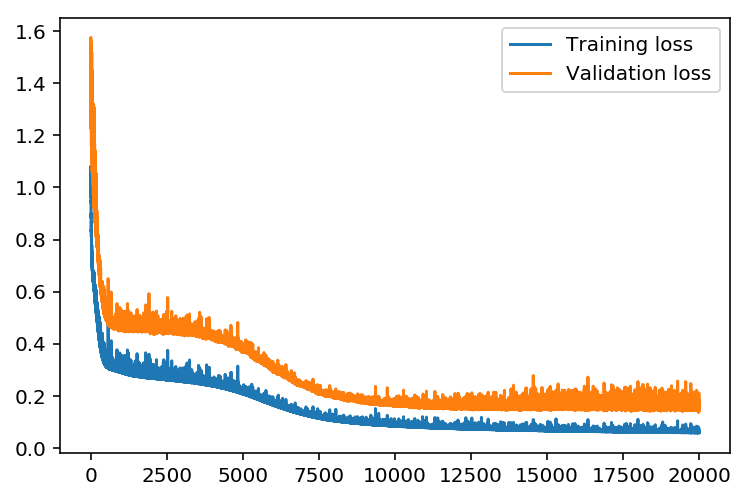

In [13]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

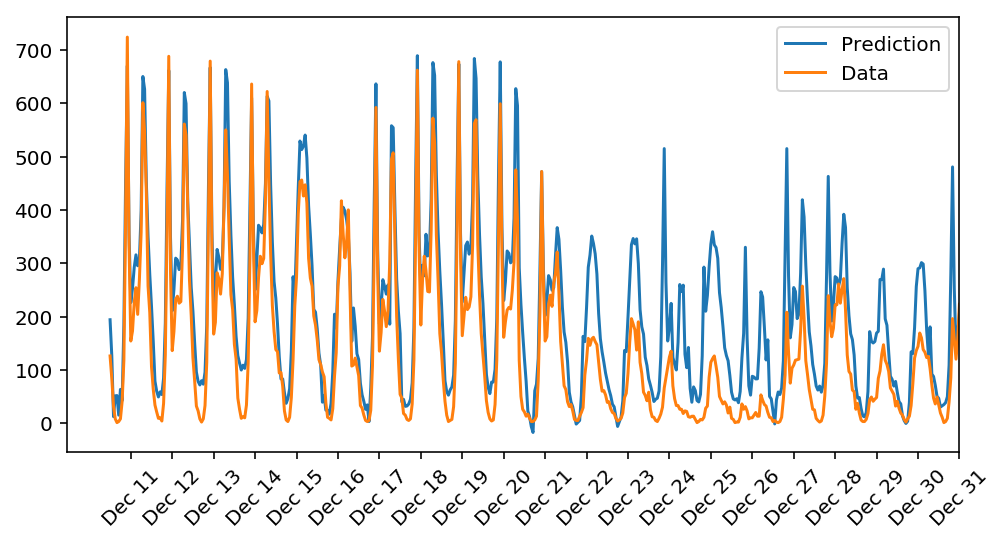

In [14]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

# dates = pd.to_datetime(rides.LOC[test_data.index]['dteday'])
dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)